# Analysis of withdrawal apply rules

Obtain as many rules as possible, and as many useful rules as possible. 

1. Try to make it work alone so that you can get >8% dispute rate
2. Generate as many rules that give you >4% as possible   

# Individual rules generation

This is the base dataset that we will work with: http://td.winnerstudio.vip:8996/#/tga/ide/59_28259

What I want to check is: 

1. If someone with different succeful rates in terms of withdrawals get to significant levels for their dispute rate 
2. If someone has been a long time without being accepted a withdrawal and different times since then
3. If someone has long time being without being accepted any payment 
4. Maybe you can also check different applied times 



## Setup code

In [1]:
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import random
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
np.random.seed(0)

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import _tree
from tqdm import tqdm

In [2]:
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script, bs_token, host):
    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 2000,
        'sql':            sql_script
    }
    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)
    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]
    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis = 1)
    return data


In [3]:
def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)
    
    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)
    
    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)
    
    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)
    
    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)
    
    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)
    
    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

def sum_withdraws_within_hours(withdraw_history, indexes):
    withdraw_history = str(withdraw_history).strip('[]')
    withdraw_values_list = [str(item.strip()) for item in withdraw_history.split(',')]
    
    # Ensure all values are numeric and calculate sum for selected indexes
    selected_withdraws = [float(withdraw_values_list[i].replace('[', '').replace(']', '')) for i in indexes 
                            if i < len(withdraw_values_list) 
                            and withdraw_values_list[i] is not None 
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != ''
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != '.']
    
    return sum(selected_withdraws)

def max_payments_in_window(payment_times, window_minutes):
    max_count = 0
    payment_times = pd.to_datetime(payment_times)
    for i, start_time in enumerate(payment_times):
        end_time = start_time + pd.Timedelta(minutes=window_minutes)
        count = np.sum((payment_times >= start_time) & (payment_times <= end_time))
        if count > max_count:
            max_count = count
    return max_count

def extract_second_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[1])
    else:
        return np.nan
    
def extract_third_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[2])
    else:
        return np.nan

def calculate_minutes_diff(start, end):
    if pd.notna(start) and pd.notna(end):
        return (end - start).total_seconds() / 60.0
    else:
        return np.nan

def get_unique_values(lst):
    return list(set(lst))

def extract_datetime(x, index):
    dates = x  # Convert JSON string to list
    if len(dates) > index:
        return pd.to_datetime(str(dates[index])[1:-1])
    else:
        return np.nan

# General function to sum payments within specified hours using the extracted indexes
def sum_payments_within_hours(payment_history, indexes):
    payment_history = str(payment_history).strip('[]')
    payment_values_list = [str(item.strip()) for item in payment_history.split(',')]
    selected_payments = [float(payment_values_list[i].replace('[', '').replace(']', '')) for i in indexes 
                            if i < len(payment_values_list) 
                            and payment_values_list[i] is not None 
                            and payment_values_list[i].replace('[', '').replace(']', '') != ''
                            and payment_values_list[i].replace('[', '').replace(']', '') != '.']
    
    return sum(selected_payments)

# Function to convert the string list to a list of datetime objects
def convert_to_datetime_list(string):
    string = str(string).strip('[]').replace("'", '"').replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    return pd.to_datetime(date_strs, format='%Y-%m-%d %H:%M:%S.%f')

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right) 
        # print('function here is okay')    
    
    else:
        leaf_size = np.sum(tree.value[node_id])
        # print('leaf_size', leaf_size)
        # print('else here is okay')
        # print(len(tree.value[node_id][0]))
        if len(tree.value[node_id][0]) > 1: 
            true_cases = tree.value[node_id][0][1]
        else: 
            true_cases = 0
        # print('else here is okay oh oh')
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        # print('有问题')
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset


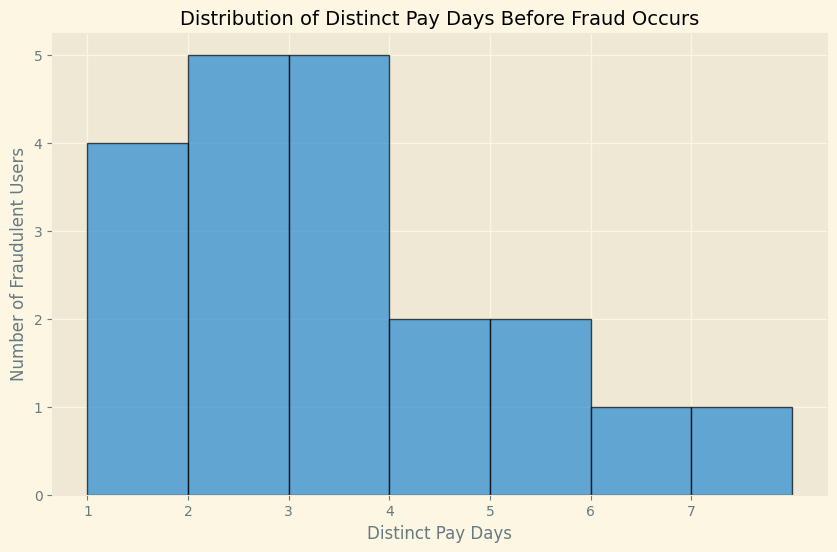

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataset: Number of distinct pay days before fraud occurred
distinct_pay_days = [1, 2, 2, 3, 1, 4, 5, 3, 2, 1, 6, 7, 4, 3, 2, 5, 3, 1, 2, 3]

# Create a DataFrame
df = pd.DataFrame({'distinct_pay_days': distinct_pay_days})

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['distinct_pay_days'], bins=range(1, max(distinct_pay_days) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Distinct Pay Days Before Fraud Occurs', fontsize=14)
plt.xlabel('Distinct Pay Days', fontsize=12)
plt.ylabel('Number of Fraudulent Users', fontsize=12)
plt.grid(True)
plt.xticks(range(1, max(distinct_pay_days) + 1))  # Ensure x-axis shows only integer pay days
plt.show()


# Day 7 analysis

## Load dispute and payment data

In [4]:
day = 7
version = 1

final_query = f"""
select * 
from temp.payments_d{day}_v{version} a
    -- join temp.games_d{day}_v{version} b    on a."#account_id" = b."#account_id"
"""

reaction_query = "losses_reaction_query"
print(final_query)



select * 
from temp.payments_d7_v1 a
    -- join temp.games_d7_v1 b    on a."#account_id" = b."#account_id"



In [1]:
df = pull_data(final_query, bs_token, host)
df['new_disputer_30d'] = df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)
df['new_disputer_30d'].mean()

NameError: name 'pull_data' is not defined

In [7]:
# Ensure the times are in datetime format
df['first_dispute_time'] = pd.to_datetime(df['first_dispute_time'])
df['first_pay_time'] = pd.to_datetime(df['first_pay_time'])

# Calculate the 'time to dispute' in hours
df['time_to_dispute'] = (df['first_dispute_time'] - df['first_pay_time']).dt.total_seconds() / 3600

# Keep out information outside the first 7 days
df = df[(df['time_to_dispute'].isnull()) | (df['time_to_dispute'] >= 168)].reset_index(drop = True)
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(5)


,first_pay_time,first_dispute_time,time_to_dispute
22031,2024-03-25 13:27:36.122,NaT,NaN
103892,2024-01-25 22:48:46.886,NaT,NaN
42546,2024-04-22 05:14:04.954,NaT,NaN
160238,2024-06-04 04:07:46.846,NaT,NaN
92767,2024-03-15 23:13:56.651,NaT,NaN


In [8]:
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(10)

,first_pay_time,first_dispute_time,time_to_dispute
155736,2023-12-28 14:04:35.676,NaT,NaN
25927,2024-04-17 21:24:28.604,NaT,NaN
143804,2024-02-02 13:11:44.952,NaT,NaN
96445,2024-04-09 18:03:33.053,NaT,NaN
167125,2024-03-17 00:59:29.269,NaT,NaN
54621,2024-01-25 01:32:25.972,NaT,NaN
22727,2024-03-17 13:38:29.125,NaT,NaN
133493,2024-01-06 14:43:22.003,NaT,NaN
133189,2024-06-08 00:12:25.534,NaT,NaN
132447,2024-04-30 22:38:05.709,NaT,NaN


## Load withdraw advanced data 

The withdrawn data is stored here: http://td.winnerstudio.vip:8996/#/tga/ide/59_31249

In [9]:
withdraw_query = f"""
select * 
from temp.withdraw_advanced a
"""
print(withdraw_query)

withdraw_query = f"""
select * 
from temp.withdraw_advanced_bundle_adjusted a
"""
print(withdraw_query)



select * 
from temp.withdraw_advanced a


select * 
from temp.withdraw_advanced_bundle_adjusted a



In [10]:
withdraw_df = pull_data(withdraw_query, bs_token, host)
print(withdraw_df.columns)
print(withdraw_df.shape)
withdraw_df.sample(5)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
Index(['#account_id', 'amount', 'applied_time', 'output', 'output_time',
       'withdraw_id'],
      dtype='object')
(57513, 6)


,#account_id,amount,applied_time,output,output_time,withdraw_id
32478,10224212,[None],[2024-01-28 06:06:08.971],[unknown],[None],[65236.0]
49658,40419542,"[100.0, None]","[2024-06-14 10:25:53.927, 2024-06-14 10:26:24....","[withdraw_success, unknown]","[2024-06-14 11:10:07.231, None]","[179207.0, 179208.0]"
16806,40310432,[6.0],[2024-05-19 02:32:16.614],[withdraw_success],[2024-05-20 02:05:39.481],[110001.0]
56627,40131264,[100.0],[2024-07-06 02:16:29.967],[withdraw_success],[2024-07-07 01:45:15.188],[244270.0]
33141,10348182,[None],[2024-02-04 01:20:11.625],[unknown],[None],[79313.0]


## Some data validation

I want to check if the numbers are correct. I want to check if there is any difference between accounts in both datasets, and understand this part. There seems to be difference due to payment method. 

In [11]:
# Withdraw part 
withdraw_df[withdraw_df['#account_id'] == '82062']
print(withdraw_df[withdraw_df['#account_id'] == '40409612'].values[0])
withdraw_df[withdraw_df['#account_id'] == '40409612']

['40409612' list([180.0, None, 75.0, 100.0, None])
 list(['2024-06-09 21:13:40.884', '2024-06-11 03:00:33.454', '2024-06-08 02:49:57.424', '2024-06-10 03:48:33.631', '2024-06-16 00:28:46.165'])
 list(['withdraw_success', 'unknown', 'withdraw_success', 'withdraw_success', 'unknown'])
 list(['2024-06-09 21:35:12.260', None, '2024-06-09 02:15:13.411', '2024-06-11 02:15:22.490', None])
 list([165770.0, 169513.0, 160956.0, 166735.0, 184185.0])]


,#account_id,amount,applied_time,output,output_time,withdraw_id
49451,40409612,"[180.0, None, 75.0, 100.0, None]","[2024-06-09 21:13:40.884, 2024-06-11 03:00:33....","[withdraw_success, unknown, withdraw_success, ...","[2024-06-09 21:35:12.260, None, 2024-06-09 02:...","[165770.0, 169513.0, 160956.0, 166735.0, 18418..."


In [16]:
df[df['#account_id'] == '82062']
df[df['#account_id'] == '10060174']
df[df['#account_id'] == '40409612'][['withdraw_history', 'withdraw_history_time']].values[0]

array([list([75.0, 180.0, 100.0]),
       list(['2024-06-09 02:15:13.411', '2024-06-09 21:35:12.260', '2024-06-11 02:15:22.490'])],
      dtype=object)

We have some users that withdraw and probably did not pay. We also might have some users that have paid but have not applied for any withdrawal within 7 days. 

In [13]:
df[df['#account_id'] == '82062']

,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,payment_enter_history,payment_history,payment_history_time,payment_methods_score,payment_methods_sequence,withdraw_history,withdraw_history_time,new_disputer_30d,time_to_dispute


In [14]:
# Let's check 
account_checked = '10060174'
check_query = f"""
select "#account_id", "#event_time" from ta.v_event_59 
where "$part_event" in ('order_pay') 
    and"$part_date" BETWEEN '2023-12-04' AND '2024-08-14'
    and payment_type in ('checkout_credit_api', 'checkout_apple_pay', 'paypal_wallet_slave')
    and "#account_id" = '{account_checked}'
"""

check_1_df = pull_data(check_query, bs_token, host)
check_1_df

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


""


Still no coincidende you might consider runnnig the query again

## Perform the join

Now you should perform the join 

In [18]:
merged_df = pd.merge(df, withdraw_df, on = '#account_id', how = 'left')
merged_df[['first_pay_time'] + list(withdraw_df.columns)].sample(5)

,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id
4505,2024-04-10 10:44:13.704,40166599,"[20.0, 20.0]","[2024-04-11 10:07:28.637, 2024-04-11 10:07:28....","[withdraw_success, withdraw_success]","[2024-04-12 02:48:18.404, 2024-04-12 02:48:18....","[43844.0, 43844.0]"
68909,2024-06-24 13:53:15.963,40180515,NaN,NaN,NaN,NaN,NaN
109321,2024-02-02 00:47:13.376,10401146,"[145.0, 45.0, 25.0, 35.0, 75.0, 50.0, 80.0, 10...","[2024-07-21 20:17:54.882, 2024-06-18 17:36:49....","[withdraw_success, withdraw_success, withdraw_...","[2024-07-22 06:15:18.102, 2024-06-19 10:27:15....","[411850.0, 369042.0, 340241.0, 340839.0, 21104..."
6606,2024-04-16 23:42:19.677,40177348,"[38.95, 1.19]","[2024-04-17 00:52:44.347, 2024-04-17 01:11:13....","[withdraw_success, withdraw_success]","[2024-04-17 02:45:14.379, 2024-04-18 01:55:07....","[51553.0, 51573.0]"
42488,2024-04-17 23:32:26.054,10693474,NaN,NaN,NaN,NaN,NaN


## Feature engineering - side trial

In [19]:
def get_valid_ids_and_times_separately(row):
    # Convert first_pay_time to Timestamp if it's not already
    first_pay_time = pd.to_datetime(row['first_pay_time'])
    
    # Ensure applied_time is a list of Timestamps and check withdraw_id
    if isinstance(row['applied_time'], list) and isinstance(row['withdraw_id'], list):
        # Convert applied_time elements to Timestamps if necessary
        applied_times = [pd.to_datetime(time) if pd.notnull(time) else None for time in row['applied_time']]
        
        # Filter valid withdraw ids where applied time is between 0 and 168 hours from first_pay_time
        valid_ids = [int(withdraw_id) for withdraw_id, applied_time in zip(row['withdraw_id'], applied_times) 
                     if pd.notnull(applied_time) and (0 <= (applied_time - first_pay_time).total_seconds() / 3600 <= 168)]
        
        valid_applied_times = [applied_time for applied_time in applied_times 
                               if pd.notnull(applied_time) and (0 <= (applied_time - first_pay_time).total_seconds() / 3600 <= 168)]
        
        return valid_ids, valid_applied_times
    return [], []  # Return empty lists if the columns aren't valid

# Apply the function to generate valid_ids and valid_applied_times columns
merged_df[['valid_ids', 'valid_applied_times']] = merged_df.apply(
    lambda row: pd.Series(get_valid_ids_and_times_separately(row)), axis=1
)

# Check a sample of the updated dataframe
merged_df[['valid_ids', 'valid_applied_times']].sample(6)

,valid_ids,valid_applied_times
145934,[],[]
42621,[],[]
128418,[],[]
127919,[],[]
116196,[],[]
144720,[],[]


In [50]:
merged_df[['valid_ids', 'valid_applied_times']].sample(6)

,valid_ids,valid_applied_times
45821,[],[]
100769,[],[]
133317,[],[]
86839,[],[]
157344,[],[]
110031,[],[]


In [20]:
def get_valid_ids(row):
    # Convert first_pay_time to Timestamp if it's not already
    first_pay_time = pd.to_datetime(row['first_pay_time'])
    
    # Ensure applied_time is a list of Timestamps and check withdraw_id
    if isinstance(row['applied_time'], list) and isinstance(row['withdraw_id'], list):
        # Convert applied_time elements to Timestamps if necessary
        applied_times = [pd.to_datetime(time) if pd.notnull(time) else None for time in row['applied_time']]
        
        # Filter valid withdraw ids where applied time is between 0 and 168 hours from first_pay_time
        valid_ids = [int(withdraw_id) for withdraw_id, applied_time in zip(row['withdraw_id'], applied_times) 
                     if pd.notnull(applied_time) and (0 <= (applied_time - first_pay_time).total_seconds() / 3600 <= 168)]
        
        return valid_ids
    return []  # Return an empty list if the column isn't valid

# Apply the function to generate valid_ids column
merged_df['valid_ids'] = merged_df.apply(get_valid_ids, axis=1)
merged_df['valid_ids'].sample(6)

134696         []
87340          []
65204          []
141405         []
138077         []
13218     [65955]
Name: valid_ids, dtype: object

In [21]:
# Step 2: Generate a column for the number of valid_ids
merged_df['num_valid_ids'] = merged_df['valid_ids'].apply(len)
merged_df['num_valid_ids'].sample(6)

7300      1
159649    0
46616     0
135798    0
32571     0
101576    0
Name: num_valid_ids, dtype: int64

In [22]:
# Step 3: Generate a column for successful withdrawals in valid_ids and output_time within 0 to 168 hours from first_pay_time
def get_successful_valid_withdrawals(row):
    first_pay_time = row['first_pay_time']
    
    # Convert first_pay_time to datetime if necessary
    if isinstance(first_pay_time, str):
        first_pay_time = pd.to_datetime(first_pay_time)

    # Check if withdraw_id, output, and output_time are lists
    if isinstance(row['withdraw_id'], list) and isinstance(row['output'], list) and isinstance(row['output_time'], list):
        valid_ids = row['valid_ids']
        successful_withdrawals = []
        
        for withdraw_id, output, output_time in zip(row['withdraw_id'], row['output'], row['output_time']):
            # Convert output_time to datetime if necessary
            if isinstance(output_time, str):
                output_time = pd.to_datetime(output_time)
            
            # Check if the withdraw is in valid_ids, is successful, and output_time is within 0 to 168 hours
            if withdraw_id in valid_ids and output == 'withdraw_success' and pd.notnull(output_time):
                hours_diff = (output_time - first_pay_time).total_seconds() / 3600
                if 0 <= hours_diff <= 168:
                    successful_withdrawals.append(withdraw_id)
        
        return successful_withdrawals
    
    return []  # Return an empty list if the column isn't valid

# Apply the function to generate the new columns
merged_df['successful_valid_withdrawals'] = merged_df.apply(get_successful_valid_withdrawals, axis=1)
merged_df['num_valid_successful_ids'] = merged_df['successful_valid_withdrawals'].apply(len)
merged_df['successful_valid_withdrawals'].sample(6)


110664                                []
4686         [32354.0, 31048.0, 32866.0]
156100                                []
3748      [235922.0, 224147.0, 224078.0]
47439                                 []
40448                                 []
Name: successful_valid_withdrawals, dtype: object

In [23]:
merged_df['valid_ids'].sample(6)

31747                                                    []
81168                                                    []
8790      [65323, 65332, 71124, 67682, 71317, 71314, 637...
103740                                                   []
153545                                                   []
157071                                                   []
Name: valid_ids, dtype: object

In [24]:
# Display the resulting dataframe
merged_df[['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_successful_ids']].sample(6)

,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_successful_ids
74898,[12011],1,[12011.0],1
148257,[],0,[],0
35064,[],0,[],0
125414,[],0,[],0
102443,[],0,[],0
101480,[],0,[],0


In [25]:
merged_df[['first_pay_time'] + list(withdraw_df.columns) + ['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_successful_ids']].sample(1).values[0]

array([Timestamp('2024-01-27 18:37:47.037000'), '10369858', nan, nan, nan,
       nan, nan, list([]), 0, list([]), 0], dtype=object)

In [26]:
merged_df[merged_df['num_valid_successful_ids'] > merged_df['num_valid_ids']][['first_pay_time'] + list(withdraw_df.columns) + ['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_successful_ids']]

,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_successful_ids


### 

## Development of the rules

### Join and features - 果实

In [27]:
modelling_df = merged_df.copy(deep = True)
modelling_df['new_disputer_30d'] = modelling_df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)

### Investigation

In [28]:
modelling_df[modelling_df['count_success_withdrawals'] > modelling_df['count_applied_times_not_exceeding']][['success_rate', 'count_success_withdrawals', 'count_applied_times_not_exceeding']].shape#head(2)

KeyError: 'count_success_withdrawals'

In [30]:

# predictors: 
modelling_df['success_rate'] = modelling_df['num_valid_successful_ids'] / modelling_df['num_valid_ids']
# modelling_df['count_applied_times_not_exceeding']
regressors_all = ['success_rate', 'num_valid_ids']

# response: new_disputer_30d

In [31]:
modelling_df[modelling_df['num_valid_successful_ids'] > modelling_df['num_valid_ids']]

,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,...,applied_time,output,output_time,withdraw_id,valid_ids,valid_applied_times,num_valid_ids,successful_valid_withdrawals,num_valid_successful_ids,success_rate


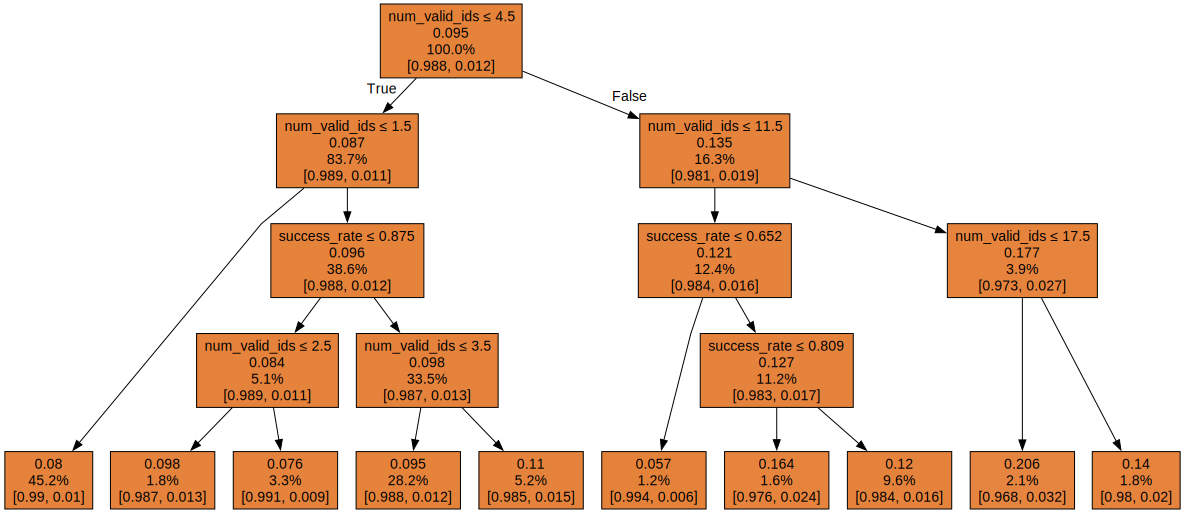

In [32]:

# train_data = modelling_df[modelling_df['sum_payments_within_168_hours'] <= 900][regressors_all + ['new_disputer_30d']].fillna(0)
train_data = modelling_df[modelling_df['num_valid_successful_ids'] > 0][regressors_all + ['new_disputer_30d']].fillna(0)
# train_data = df_7d[regressors_all + ['new_disputer_30d']].fillna(0)
X_train, y_train = train_data.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 

criterion = 'log_loss' 
depth = 4
leaf_size = 280

clf = create_model(criterion, depth, leaf_size)
clf.fit(X_train, y_train)
clf = clf[0]

dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           # ,  feature_names = cols
                           # ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)

### Plotamina

In [33]:
train_data[train_data['success_rate'] < 0] 
train_data[train_data['success_rate'] > 0][train_data['success_rate'] < 1]['new_disputer_30d'].mean()
# train_data[train_data['success_rate'] > 0][train_data['success_rate'] < 0.8]['new_disputer_30d'].mean()

0.014969085584119753

In [34]:
modelling_df[modelling_df['num_valid_successful_ids'] == 0].shape[0] / modelling_df.shape[0]

0.8492683152192745

In [35]:
train_data.shape

(26101, 3)

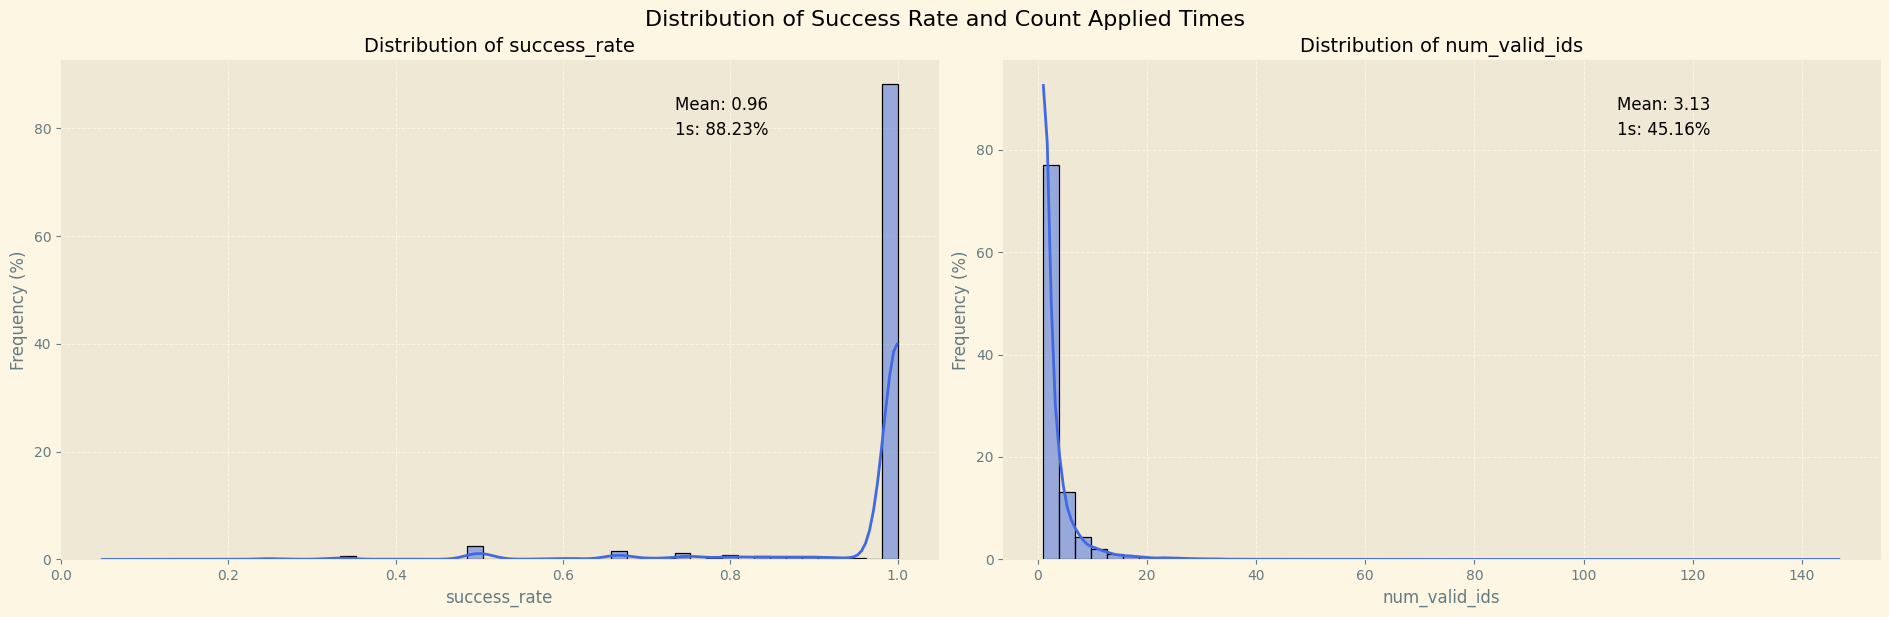

In [36]:
# Set the style to a professional look
plt.style.use('Solarize_Light2')  # Consulting-friendly and scientific style

# Function to plot the distribution of both columns and display mean and percentage of 0s
def plot_distributions(df, columns):
    fig, axes = plt.subplots(1, 2, figsize=(19, 6))

    for ax, column in zip(axes, columns):
        # Calculate mean and percentage of 0s
        mean_value = df[column].mean()
        zero_percentage = (df[column] == 1).mean() * 100
        
        # Plot histogram with KDE
        sns.histplot(df[column], bins=50, kde=True, ax=ax, color='royalblue', stat='percent')
        
        # Annotate the plot with mean and zero percentage
        ax.text(0.7, 0.9, f'Mean: {mean_value:.2f}', transform=ax.transAxes, fontsize=12, color='black')
        ax.text(0.7, 0.85, f'1s: {zero_percentage:.2f}%', transform=ax.transAxes, fontsize=12, color='black')
        
        # Set titles and labels
        ax.set_title(f'Distribution of {column}', fontsize=14)
        ax.set_xlabel(column, fontsize=12)
        ax.set_ylabel('Frequency (%)', fontsize=12)
        ax.grid(True, linestyle='--', linewidth=0.7)

    # Adjust layout and show the plots
    # plt.figure(figsize=(25, 8))
    plt.tight_layout()
    plt.suptitle('Distribution of Success Rate and Count Applied Times', fontsize=16, y=1.02)
    plt.show()

# Call the function with the dataset and the columns to plot
plot_distributions(train_data[train_data['num_valid_ids'] > 0], ['success_rate', 'num_valid_ids'])


In [37]:
train_data['new_version'] = train_data['num_valid_ids'] + 1
train_data['new_version']

0        3
1        2
2        5
3        2
4        3
        ..
79660    5
79661    3
79662    2
79663    2
79664    6
Name: new_version, Length: 26101, dtype: int64

In [38]:
train_data['new_disputer_30d'].mean()

0.012260066664112486

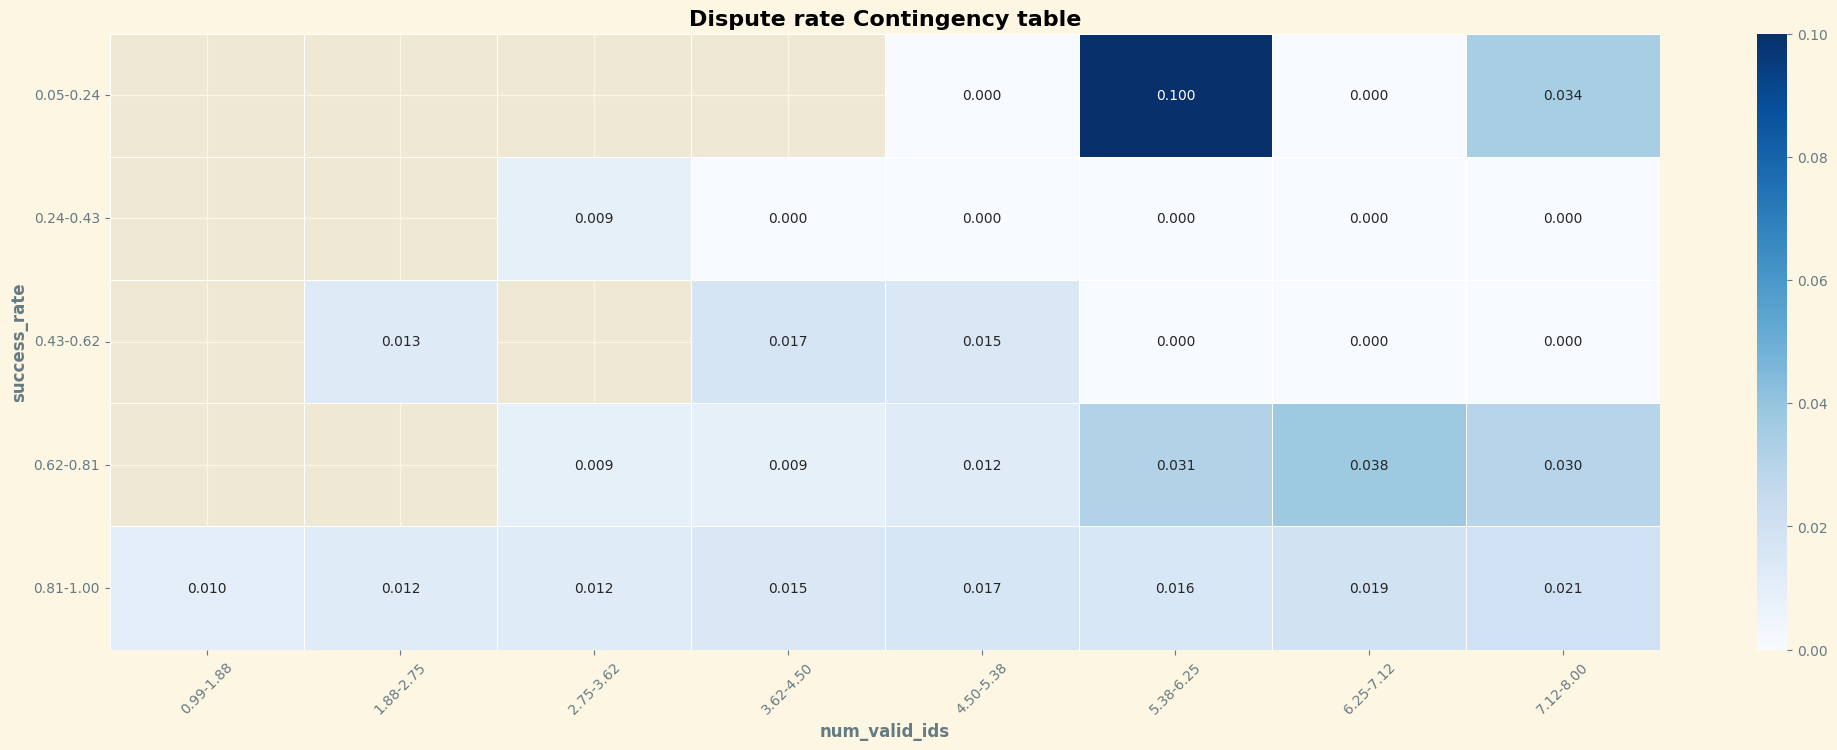

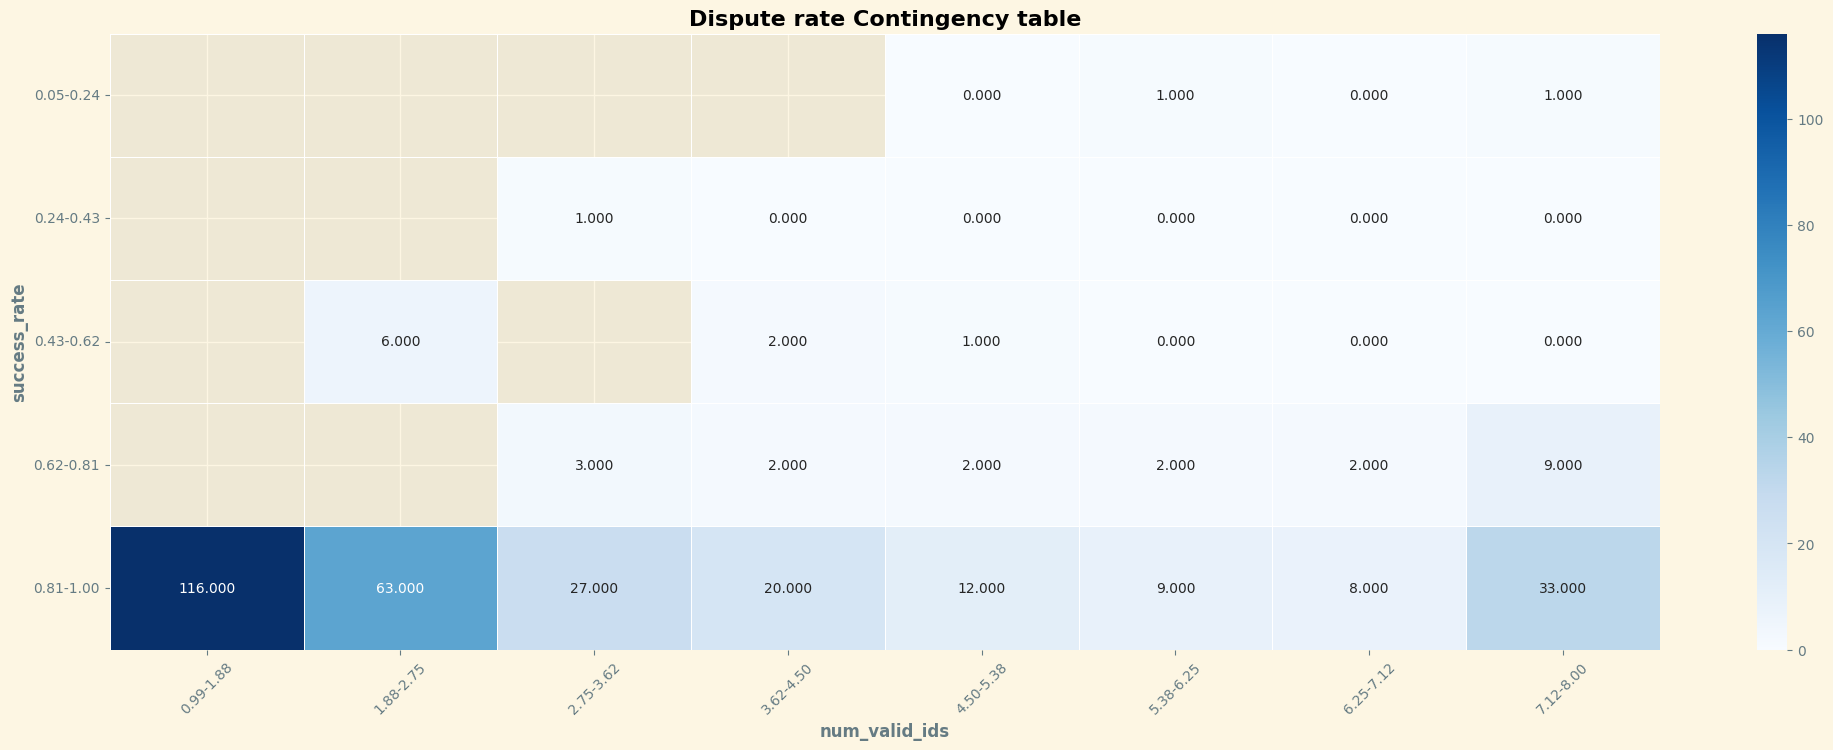

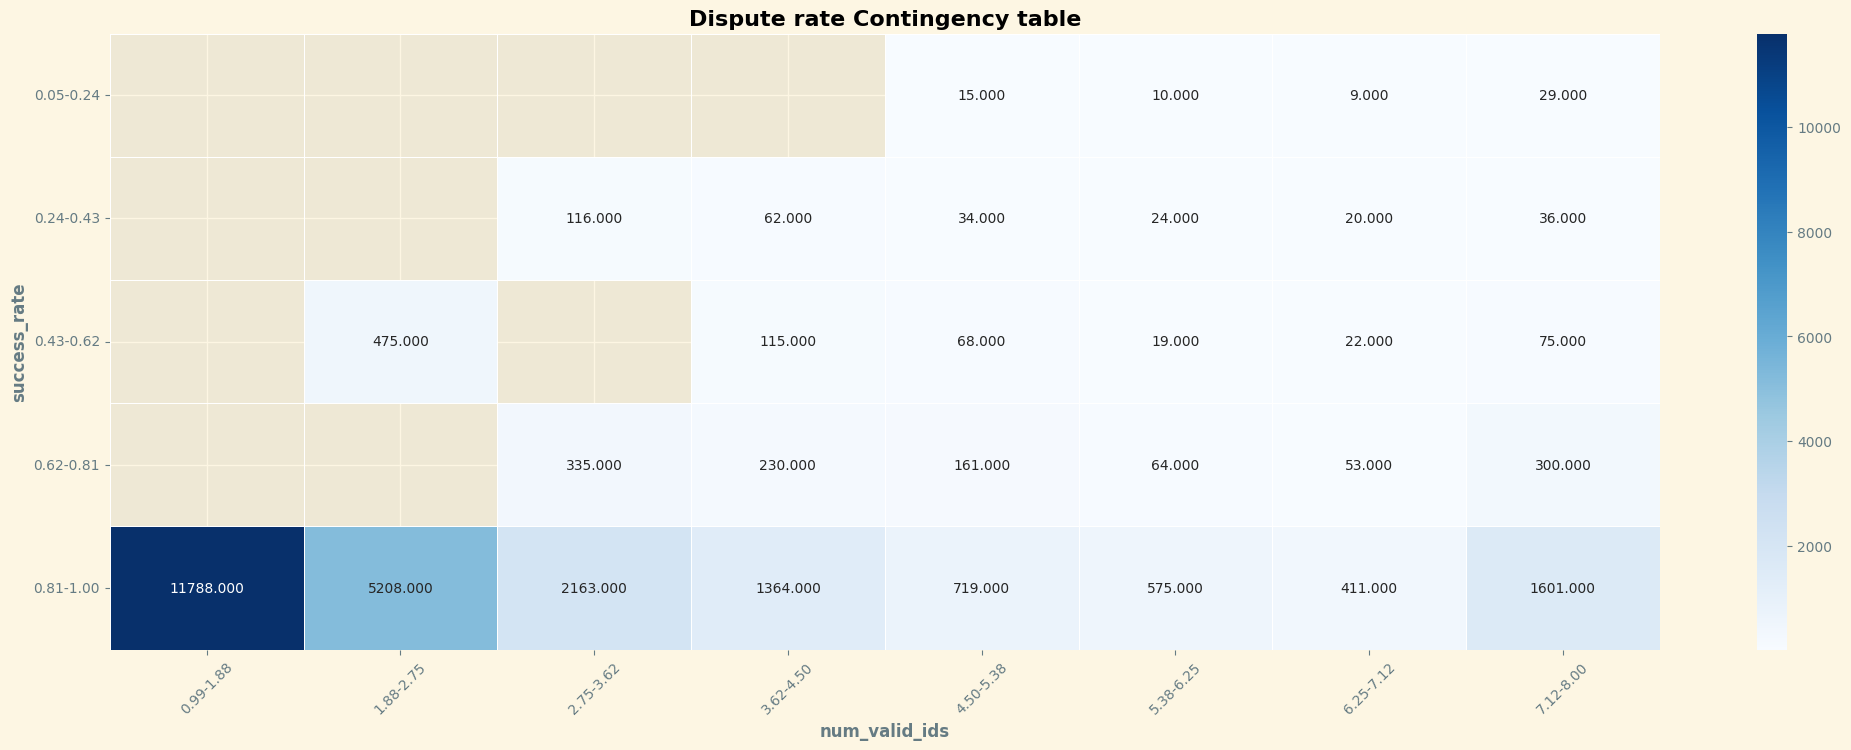

In [39]:
# Calculate equally spaced values and get the edges
def create_and_plot_pivot_table(df, xlabel, ylabel, aggfunc, title, response_name, y_k, x_k, y_limit_number, x_limit_number):
    
    # Apply limits before cutting the data
    df[xlabel] = df[xlabel].where(df[xlabel] < x_limit_number, x_limit_number)
    df[ylabel] = df[ylabel].where(df[ylabel] < y_limit_number, y_limit_number)

    # Use pd.cut for equally spaced bins, applying limits
    df[f'{xlabel}_bin'], concerning_bets_user_bins = pd.cut(df[xlabel], bins=x_k, labels=False, retbins=True)
    df[f'{ylabel}_bin'], bets_user_bins = pd.cut(df[ylabel], bins=y_k, labels=False, retbins=True)

    # Remove NaN values that may arise due to empty bins
    df = df.dropna(subset=[f'{xlabel}_bin', f'{ylabel}_bin'])

    # Create labels for the equally spaced bins
    index_labels = [f'{bets_user_bins[i]:.2f}-{bets_user_bins[i+1]:.2f}' for i in range(len(bets_user_bins)-1)]
    columns_labels = [f'{concerning_bets_user_bins[i]:.2f}-{concerning_bets_user_bins[i+1]:.2f}' for i in range(len(concerning_bets_user_bins)-1)]

    # Create the pivot table
    contingency_table = df.pivot_table(
        index=f'{ylabel}_bin',
        columns=f'{xlabel}_bin',
        values=response_name,
        aggfunc=aggfunc
    )

    # Replace bin numbers with labels
    contingency_table.index = index_labels
    contingency_table.columns = columns_labels

    # Plotting in McKinsey-style format
    plt.figure(figsize=(25, 8))
    sns.heatmap(contingency_table, annot=True, fmt=".3f", cmap="Blues", cbar=True, linewidths=.5)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Example usage with equally spaced bins and separate limits:
# Example usage with equally spaced bins:
train_data['new_version'] = train_data['new_disputer_30d'] + 1
create_and_plot_pivot_table(train_data, 'num_valid_ids', 'success_rate', np.mean, 'Dispute rate Contingency table', 'new_disputer_30d', y_k=5, x_k=8, y_limit_number=5, x_limit_number=8)
create_and_plot_pivot_table(train_data, 'num_valid_ids', 'success_rate', np.sum, 'Dispute rate Contingency table', 'new_disputer_30d', y_k=5, x_k=8, y_limit_number=5, x_limit_number=8)
create_and_plot_pivot_table(train_data, 'num_valid_ids', 'success_rate', np.count_nonzero, 'Dispute rate Contingency table', 'new_version', y_k=5, x_k=8, y_limit_number=5, x_limit_number=8)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


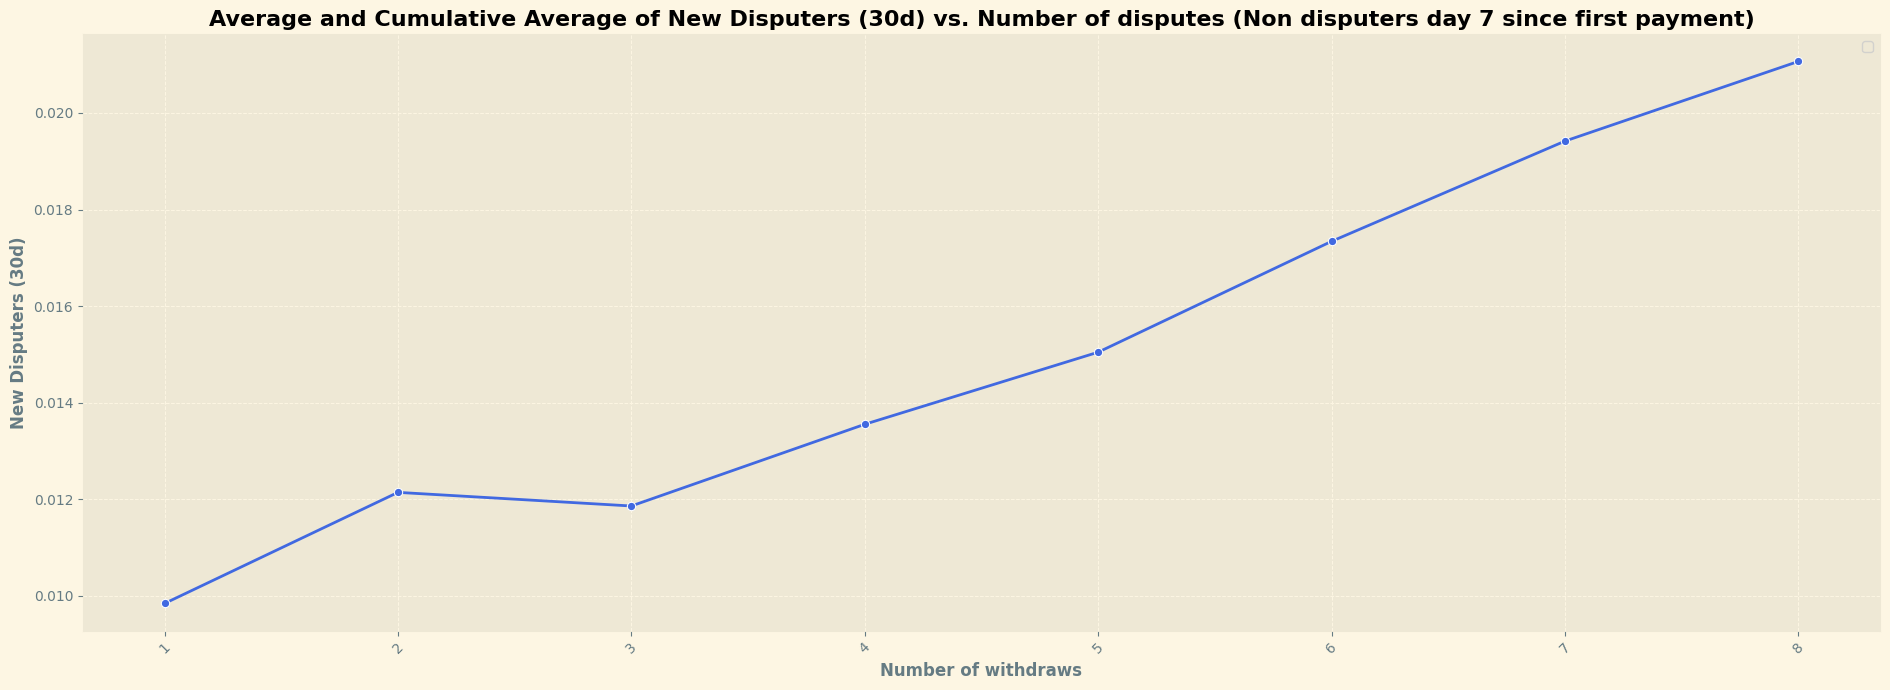

In [40]:
average_disputers = train_data.groupby('num_valid_ids')['new_disputer_30d'].mean().reset_index()
average_disputers['cumulative_sum'] = average_disputers['new_disputer_30d'].cumsum()
average_disputers['cumulative_count'] = ((average_disputers['new_disputer_30d'] + 1)/(average_disputers['new_disputer_30d'] + 1)).cumsum()
average_disputers['cumulative_average'] = average_disputers['cumulative_sum'] / average_disputers['cumulative_count']

# Set the style to a professional look
plt.style.use('Solarize_Light2')

# Create the plot
plt.figure(figsize=(19, 7))

# Plot average
sns.lineplot(data=average_disputers, x='num_valid_ids', y='new_disputer_30d', color='royalblue', marker='o')

# Plot cumulative average
# sns.lineplot(data=average_disputers, x='num_valid_ids', y='cumulative_average', color='orange', marker='o')

# Customizing the plot
plt.title('Average and Cumulative Average of New Disputers (30d) vs. Number of disputes (Non disputers day 7 since first payment)', fontsize=16, fontweight='bold')
plt.xlabel('Number of withdraws', fontsize=12, fontweight='bold')
plt.ylabel('New Disputers (30d)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
modelling_df['new_disputer_30d'].mean()

0.0073110728681812405

In [42]:
train_data['new_disputer_30d'].mean()


0.012260066664112486

In [136]:

# Step 1: Create the new group column based on success_rate
def categorize_success_rate(success_rate):
    if success_rate <= 0:
        return '0'
    elif success_rate < 1:
        return '(0, 1)'
    else:
        return '1'

train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

def create_quantile_labels(series, n_quantiles):

    return pd.qcut(
        series, 
        q=n_quantiles, 
        labels=[f'Quantile {i + 1}' for i in range(n_quantiles)],
        duplicates='drop'  # Avoid duplicate bin edges
    )

# Example usage:
train_data['quantiles'] = create_quantile_labels(train_data['count_applied_times_not_exceeding'], 5)  # Create 5 quantiles

# Step 2: Plot the average of 'new_disputer_30d' for each group of 'success_rate_group' and 'count_applied_times_not_exceeding_quantile'
def plot_success_rate_vs_disputer(df):
    plt.figure(figsize=(12, 6))
    
    # Plot each 'count_applied_times_not_exceeding_quantile' group with a different line
    for group in df['quantiles'].unique():
        group_data = df[df['quantiles'] == group]
        sns.lineplot(
            data=group_data, 
            x='success_rate_group', 
            y='new_disputer_30d', 
            label=f'{group} Quantile',
            marker='o'
        )

    # Set titles and labels
    plt.title('Average new_disputer_30d by Success Rate Group and Count Applied Times Quantile', fontsize=16)
    plt.xlabel('Success Rate Group', fontsize=12)
    plt.ylabel('Average new_disputer_30d', fontsize=12)
    plt.legend(title='Count Applied Times Quantile', loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Step 3: Call the function to plot the data
plot_success_rate_vs_disputer(train_data)


ValueError: Bin labels must be one fewer than the number of bin edges

In [131]:
train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

In [148]:
train_data.groupby('success_rate_group')['new_disputer_30d'].mean()
train_data_filtered = train_data[train_data['success_rate_group'] == '(0, 1)']

train_data_filtered['success_rate_group_quantiles'] = create_quantile_labels(train_data_filtered['success_rate'].astype(float), 4)  # Create 5 quantiles

# train_data_filtered.groupby('success_rate_group_quantiles')['new_disputer_30d'].mean()

train_data_filtered.groupby('success_rate_group_quantiles').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()


,success_rate_group_quantiles,mean_new_disputer,sum_new_disputer
0,Quantile 1,0.027778,3
1,Quantile 2,0.070866,9
2,Quantile 3,0.000000,0
3,Quantile 4,0.000000,0


In [155]:
train_data_filtered['count_applied_times_not_exceeding']

0         2
1         1
2         4
3         1
4         2
         ..
171273    2
171738    1
171796    2
171801    2
172028    1
Name: count_applied_times_not_exceeding, Length: 27236, dtype: int64

In [224]:
import pandas as pd

# Step 1: Filter the DataFrame for success_rate_group '0'
train_data_filtered = train_data[train_data['success_rate_group'] == '0'].copy()

# Step 2: Ensure the count_applied_times_not_exceeding column is numeric
train_data_filtered['count_applied_times_not_exceeding'] = pd.to_numeric(
    train_data_filtered['count_applied_times_not_exceeding'], errors='coerce'
)

# Step 3: Drop NaN values from the relevant column
train_data_filtered.dropna(subset=['count_applied_times_not_exceeding'], inplace=True)

# Step 4: Calculate the number of unique values
n_unique = train_data_filtered['count_applied_times_not_exceeding'].nunique()
n_quantiles = min(3, n_unique)  # Set to the minimum of requested quantiles or unique values

# Create quantile labels
def create_quantile_labels(series, n_quantiles):
    # If there are not enough unique values, return a series of None
    if len(series) < 2 or n_quantiles < 1:  
        return pd.Series([None] * len(series))
    
    # Use pd.qcut with duplicates='drop'
    return pd.qcut(
        series,
        q=n_quantiles,
        labels=[f'Quantile {i + 1}' for i in range(n_quantiles)],
        duplicates='drop'  # Avoid duplicate bin edges
    )

# Apply the quantile creation function
train_data_filtered['quantis'] = create_quantile_labels(train_data_filtered['count_applied_times_not_exceeding'], 2)

# Group by the quantile labels and calculate mean and sum of new_disputer_30d
summary_stats = train_data_filtered.groupby('count_applied_times_not_exceeding').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()

# Display the results
summary_stats


,count_applied_times_not_exceeding,mean_new_disputer,sum_new_disputer
0,1,0.003403,44
1,2,0.004062,24
2,3,0.003079,8
3,4,0.001157,2
4,5,0.003093,3
...,...,...,...
71,111,0.000000,0
72,119,0.000000,0
73,129,0.000000,0
74,140,1.000000,2


In [226]:
# Step 1: Convert the column to integer
train_data_filtered = train_data[train_data['success_rate_group'] == '0'].copy()+
train_data_filtered['count_applied_times_not_exceeding'] = train_data_filtered['count_applied_times_not_exceeding'].astype(int)

# Step 2: Apply the condition to transform the values
train_data_filtered['count_applied_times_not_exceeding'] = train_data_filtered['count_applied_times_not_exceeding'].apply(
    lambda x: ">4" if x >= 4 else x
)

train_data_filtered.groupby('count_applied_times_not_exceeding').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()


,count_applied_times_not_exceeding,mean_new_disputer,sum_new_disputer
0,1,0.003403,44
1,2,0.004062,24
2,3,0.003079,8
3,>4,0.002932,17


In [222]:
train_data_filtered['count_applied_times_not_exceeding'].sample(5)

73238     3
71507     1
724      11
1125      1
17802     1
Name: count_applied_times_not_exceeding, dtype: int64

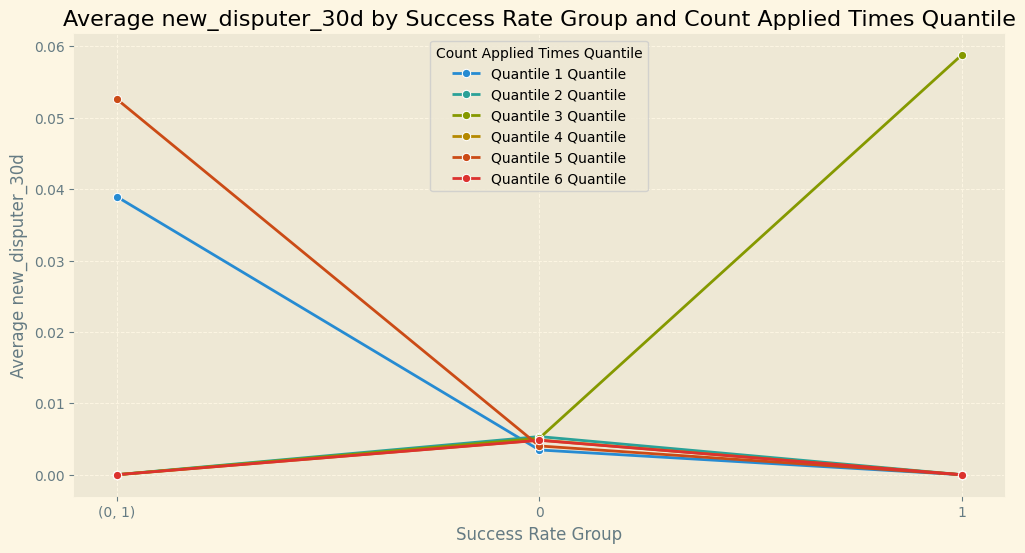

In [120]:
def categorize_success_rate(success_rate):
    if success_rate <= 0:
        return '0'
    elif success_rate < 1:
        return '(0, 1)'
    else:
        return '1'

train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

def create_quantile_labels(series, n_quantiles):
    series = series.dropna()
    unique_values = series.nunique()
    n_quantiles = min(n_quantiles, unique_values)
    quantiles = pd.qcut(series, q=n_quantiles, labels=False, duplicates='drop')
    unique_quantiles = quantiles.unique()
    labels = [f'Quantile {i + 1}' for i in range(len(unique_quantiles))]
    quantile_labels = pd.Series(labels, index=unique_quantiles)
    return quantile_labels[quantiles].reset_index(drop=True)

# Create quantiles for count_applied_times_not_exceeding
train_data['quantiles'] = create_quantile_labels(train_data['count_applied_times_not_exceeding'], 20)

# Step 2: Calculate average new_disputer_30d for each combination of success_rate_group and quantiles
grouped_data = (train_data
                .groupby(['success_rate_group', 'quantiles'])
                .agg(average_new_disputer=('new_disputer_30d', 'mean'))
                .reset_index())

# Step 3: Plot the average of 'new_disputer_30d' for each group of 'success_rate_group' and 'quantiles'
def plot_success_rate_vs_disputer(grouped_data):
    plt.figure(figsize=(12, 6))

    # Plot each 'count_applied_times_not_exceeding_quantile' group with a different line
    for group in grouped_data['quantiles'].unique():
        group_data = grouped_data[grouped_data['quantiles'] == group]
        
        # Ensure there is data to plot
        if not group_data.empty:
            sns.lineplot(
                data=group_data, 
                x='success_rate_group', 
                y='average_new_disputer', 
                label=f'{group} Quantile',
                marker='o'
            )

    # Set titles and labels
    plt.title('Average new_disputer_30d by Success Rate Group and Count Applied Times Quantile', fontsize=16)
    plt.xlabel('Success Rate Group', fontsize=12)
    plt.ylabel('Average new_disputer_30d', fontsize=12)
    plt.legend(title='Count Applied Times Quantile', loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Step 4: Call the function to plot the data
plot_success_rate_vs_disputer(grouped_data)


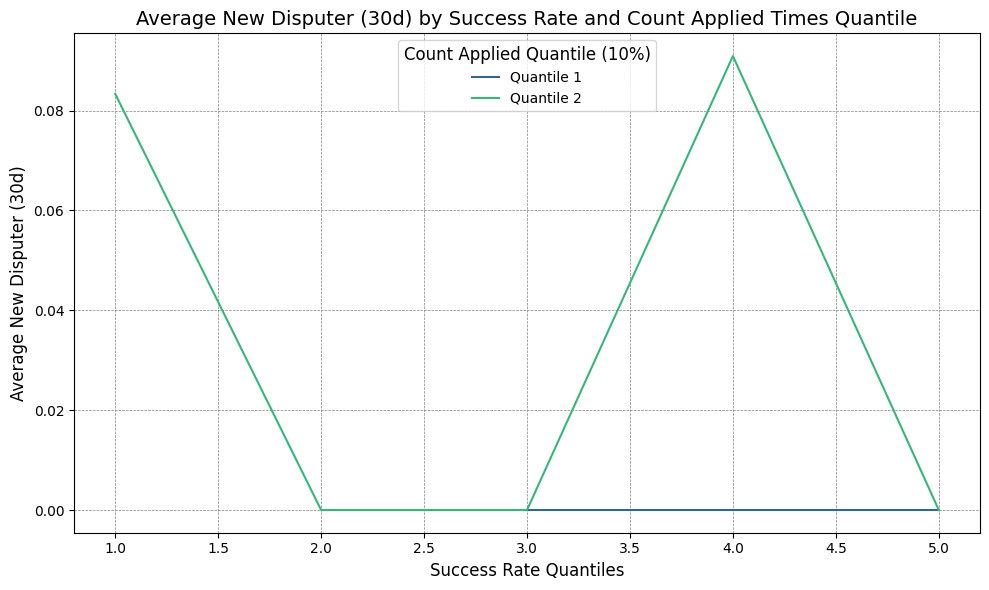

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create the desired chart
def plot_success_rate_vs_disputer(df, x_column, y_column, color_column, num_quantiles, drop_duplicates=True):
    # Option to handle non-unique bin edges by ranking or dropping duplicates
    if drop_duplicates:
        df = df.drop_duplicates(subset=[x_column, color_column])

    # Calculate quantiles for success_rate (X-axis) and count_applied_times_not_exceeding (Color)
    df['success_rate_quantile'] = pd.qcut(df[x_column].rank(method='first'), q=5, labels=np.arange(1, 6))  # 10 quantiles for success_rate
    df['count_applied_quantile'] = pd.qcut(df[color_column].rank(method='first'), q=num_quantiles, labels=np.arange(1, num_quantiles + 1))  # 8 quantiles for color

    # Group by success_rate_quantile and count_applied_quantile, and calculate the mean of new_disputer_30d
    grouped = df.groupby(['success_rate_quantile', 'count_applied_quantile'])[y_column].mean().reset_index()

    # Pivot the data to get the format needed for plotting
    pivot_df = grouped.pivot(index='success_rate_quantile', columns='count_applied_quantile', values=y_column)

    # McKinsey-style and scientific-style chart setup
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", num_quantiles)  # Use a scientific color palette

    # Plot each quantile as a separate line
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f'Quantile {col}', color=colors[int(col)-1])

    # Add labels and title
    plt.title('Average New Disputer (30d) by Success Rate and Count Applied Times Quantile', fontsize=14)
    plt.xlabel('Success Rate Quantiles', fontsize=12)
    plt.ylabel('Average New Disputer (30d)', fontsize=12)

    # Add grid, legend, and format
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.legend(title='Count Applied Quantile (10%)', title_fontsize=12, fontsize=10)
    
    # Set valid style
    plt.style.use('Solarize_Light2')  # Valid style name

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage (assuming merged_df is the DataFrame)
plot_success_rate_vs_disputer(train_data, 'success_rate', 'new_disputer_30d', 'count_applied_times_not_exceeding', num_quantiles=2)


### Concentration of withdrawals in period of time 

In [51]:
modelling_df['valid_applied_times']

0         [2024-04-12 18:22:07.551000, 2024-04-12 18:22:...
1                              [2024-04-04 20:00:03.412000]
2         [2023-12-08 06:59:56.117000, 2023-12-08 04:37:...
3                              [2023-12-08 21:23:45.623000]
4         [2023-12-12 00:18:50.492000, 2023-12-05 06:07:...
                                ...                        
173157                                                   []
173158                                                   []
173159                         [2024-03-27 02:24:21.963000]
173160                                                   []
173161                                                   []
Name: valid_applied_times, Length: 173162, dtype: object

In [53]:
# You need to make sure you have only the relevant cases (Applications in 7 days)

# You convert it into date time (Then this way you have the dataset ready for check)

# Function to convert the string list to a list of datetime objects
# Function to convert string list to list of datetime objects, or handle existing timestamps
def convert_to_datetime_list(entry):
    # If it's already a list of datetime objects, return it as-is
    if isinstance(entry, list) and all(isinstance(item, pd.Timestamp) for item in entry):
        return entry
    
    # If entry is a string, process it
    string = str(entry).strip('[]').replace("'", '"').replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')
    string = string.strip()
    
    # Split and clean date strings
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    
    # Convert the date strings to datetime objects
    return pd.to_datetime(date_strs, errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')

# Apply the function to the dataframe
withdrawers_data = modelling_df[modelling_df['num_valid_successful_ids'] > 0].fillna(0)
withdrawers_data['valid_applied_times_clean'] = withdrawers_data['valid_applied_times'].apply(convert_to_datetime_list)

# Sample check
withdrawers_data['valid_applied_times_clean'].sample(6)

7977     [2024-05-09 22:45:48.467000, 2024-05-12 03:38:...
4615                          [2024-04-20 03:18:05.081000]
3836     [2024-01-06 02:43:33.370000, 2023-12-30 04:39:...
76745    [2024-02-08 12:04:53.679000, 2024-02-08 12:34:...
5139                          [2024-01-15 19:31:52.716000]
10950    [2023-12-30 06:00:11.976000, 2023-12-30 05:44:...
Name: valid_applied_times_clean, dtype: object

In [62]:
# Function to count valid payments within the specified indexes
def count_payments_within_hours(payment_history, indexes):
    # Strip the brackets and split the payment history string
    payment_history = str(payment_history).strip('[]')
    payment_values_list = [str(item.strip()) for item in payment_history.split(',')]
    
    # Count the valid payments within the specified indexes
    valid_payments_count = sum(1 for i in indexes 
                                if i < len(payment_values_list) 
                                and payment_values_list[i] is not None 
                                and payment_values_list[i].replace('[', '').replace(']', '') != ''
                                and payment_values_list[i].replace('[', '').replace(']', '') != '.')
    
    return valid_payments_count


In [63]:
# withdrawers_data['payment_history_time'] = withdrawers_data['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')
withdrawers_data['valid_applied_times_time'] = withdrawers_data['valid_applied_times'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')
withdrawers_data['first_pay_time'] = pd.to_datetime(withdrawers_data['first_pay_time'])

for hours in [0.25, 0.5, 1, 24, 168]:
    print(hours)
    col_index_name = f'indexes_within_{hours}_hours'
    col_sum_name = f'sum_withdrawals_within_{hours}_hours'
    withdrawers_data[col_index_name] = withdrawers_data.apply(lambda row: extract_within_hours(row['valid_applied_times_clean'], row['first_pay_time'], hours), axis=1)
    withdrawers_data[col_sum_name] = withdrawers_data.apply(lambda row: count_payments_within_hours(row['valid_applied_times_time'], row[col_index_name]), axis=1)
    # withdrawers_data.drop(columns=[col_index_name], inplace=True) 


0.25
0.5
1
24
168


In [66]:
withdrawers_data.columns

Index(['#account_id', 'already_disputed', 'bundle_id', 'disputable_payment',
       'disputed_amount_d30', 'disputes_d30', 'first_dispute_time',
       'first_pay_time', 'hours_first_payment', 'payment_d7',
       'payment_enter_history', 'payment_history', 'payment_history_time',
       'payment_methods_score', 'payment_methods_sequence', 'withdraw_history',
       'withdraw_history_time', 'new_disputer_30d', 'time_to_dispute',
       'amount', 'applied_time', 'output', 'output_time', 'withdraw_id',
       'valid_ids', 'valid_applied_times', 'num_valid_ids',
       'successful_valid_withdrawals', 'num_valid_successful_ids',
       'success_rate', 'valid_applied_times_clean',
       'indexes_within_0.25_hours', 'valid_applied_times_time',
       'sum_withdrawals_within_0.25_hours', 'indexes_within_0.5_hours',
       'sum_withdrawals_within_0.5_hours', 'indexes_within_1_hours',
       'sum_withdrawals_within_1_hours', 'indexes_within_24_hours',
       'sum_withdrawals_within_24_hours', 

In [79]:
conc_regressors_all = ['sum_withdrawals_within_0.25_hours', 
       'sum_withdrawals_within_0.5_hours', 
       'sum_withdrawals_within_1_hours', 
       'sum_withdrawals_within_24_hours', 
       'sum_withdrawals_within_168_hours']
withdrawers_data[withdrawers_data['num_valid_successful_ids'] > 0][conc_regressors_all].sample(6)

,sum_withdrawals_within_0.25_hours,sum_withdrawals_within_0.5_hours,sum_withdrawals_within_1_hours,sum_withdrawals_within_24_hours,sum_withdrawals_within_168_hours
2969,0,0,0,0,1
8874,0,0,0,0,1
12583,0,0,1,1,1
930,0,0,0,0,1
6516,0,0,1,2,3
18661,0,0,0,0,1


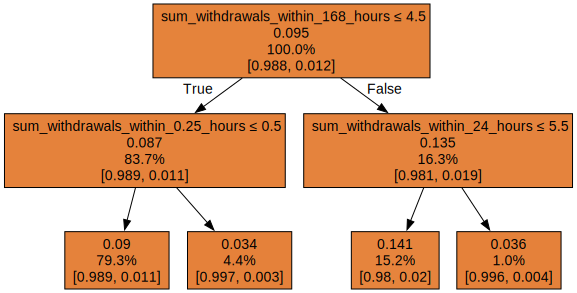

In [83]:
train_data_concentration = withdrawers_data[withdrawers_data['num_valid_successful_ids'] > 0][conc_regressors_all + ['new_disputer_30d']].fillna(0)
X_train, y_train = train_data_concentration.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 

criterion = 'log_loss' 
depth = 2
leaf_size = 80

clf = create_model(criterion, depth, leaf_size)
clf.fit(X_train, y_train)
clf = clf[0]

dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           # ,  feature_names = cols
                           # ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)

### Check concentration with decision tree

In [ ]:
###

### Some confirmation

- Why do you have negative values? 

- You know that non-integer success rates are not necessarily giving high dispute rates

- 0% is better than 1%, is 0% dangerous if applications have been made more times

- Is there any insight within non-integer rates?

# Planification of rules for reporting 

In [ ]:
# According to the map, you only should be lookoing at the count_applied_times_not_exceeding. Because the numbers in terms of success rate don't make much sense 

# Day 1 analysis

## Load dispute and payment data

In [391]:
day = 7
version = 1

final_query = f"""
select * 
from temp.payments_d{day}_v{version} a
    -- join temp.games_d{day}_v{version} b    on a."#account_id" = b."#account_id"
"""

reaction_query = "losses_reaction_query"
print(final_query)



select * 
from temp.payments_d7_v1 a
    -- join temp.games_d7_v1 b    on a."#account_id" = b."#account_id"



In [392]:
df = pull_data(final_query, bs_token, host)
print(df.columns)
df.sample(5)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
Index(['#account_id', 'already_disputed', 'bundle_id', 'disputable_payment',
       'disputed_amount_d30', 'disputes_d30', 'first_dispute_time',
       'first_pay_time', 'hours_first_payment', 'payment_d7',
       'payment_enter_history', 'payment_history', 'payment_history_time',
       'payment_methods_score', 'payment_methods_sequence', 'withdraw_history',
       'withdraw_history_time'],
      dtype='object')


,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,payment_enter_history,payment_history,payment_history_time,payment_methods_score,payment_methods_sequence,withdraw_history,withdraw_history_time
93980,40350539,0,com.asselin.luckylegends,0.0,0.0,0,NaN,2024-05-27 22:27:18.523,0,7.3832,"[default, first_b]","[4.6395, 2.7437]","[2024-05-27 22:27:18.523, 2024-05-30 06:28:32....",1,[checkout_apple_pay],NaN,NaN
58020,40363049,0,com.asselin.luckylegends,0.0,0.0,0,NaN,2024-05-30 23:27:28.137,15,9.3790,[lucky_flip],[9.379],[2024-05-30 23:27:28.137],1,[checkout_apple_pay],NaN,NaN
122437,10223431,0,com.acorncasino.slots,0.0,0.0,0,NaN,2024-01-04 21:44:22.653,0,13.9300,"[first_b, first_b]","[2.726, 11.204]","[2024-01-04 21:44:22.653, 2024-01-04 21:49:58....",1,[checkout_credit_api],NaN,NaN
117018,10624504,0,com.acorncasino.slots,0.0,0.0,0,NaN,2024-04-01 04:21:05.563,0,9.2200,"[default, default]","[4.61, 4.61]","[2024-04-01 04:21:05.563, 2024-04-01 04:35:02....",1,[checkout_apple_pay],NaN,NaN
93687,10616152,0,com.acorncasino.slots,0.0,0.0,0,NaN,2024-03-30 13:38:55.686,0,1.7840,[default],[1.784],[2024-03-30 13:38:55.686],1,[checkout_apple_pay],NaN,NaN


In [397]:
df['new_disputer_30d'] = df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)
df['new_disputer_30d'].mean()

0.0073110728681812405

In [396]:
# Ensure the times are in datetime format
df['first_dispute_time'] = pd.to_datetime(df['first_dispute_time'])
df['first_pay_time'] = pd.to_datetime(df['first_pay_time'])

# Calculate the 'time to dispute' in hours
df['time_to_dispute'] = (df['first_dispute_time'] - df['first_pay_time']).dt.total_seconds() / 3600

# Keep out information outside the first 7 days
df = df[(df['time_to_dispute'].isnull()) | (df['time_to_dispute'] >= 168)].reset_index(drop = True)
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(5)


,first_pay_time,first_dispute_time,time_to_dispute
38923,2024-04-24 22:02:52.112,NaT,NaN
163817,2024-01-05 19:28:26.867,NaT,NaN
120029,2024-02-05 23:13:11.272,NaT,NaN
40746,2023-12-04 15:00:03.619,NaT,NaN
143200,2024-05-22 10:29:57.229,NaT,NaN


In [ ]:
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(10)

,first_pay_time,first_dispute_time,time_to_dispute
112274,2024-01-07 15:46:07.589,2024-01-09 04:33:03.535,36.782207
115360,2024-05-23 01:58:43.998,NaT,NaN
92607,2024-03-30 16:21:34.133,NaT,NaN
111200,2024-01-15 05:08:41.403,NaT,NaN
12224,2024-06-03 00:04:51.401,NaT,NaN
19839,2024-04-18 02:53:48.457,NaT,NaN
52947,2024-05-20 23:54:21.788,NaT,NaN
92810,2024-06-30 00:36:56.876,NaT,NaN
1038,2024-04-04 17:09:51.782,NaT,NaN
34168,2024-01-06 01:29:29.615,NaT,NaN


## Load withdraw advanced data 

The withdrawn data is stored here: http://td.winnerstudio.vip:8996/#/tga/ide/59_31249

In [ ]:
withdraw_query = f"""
select * 
from temp.withdraw_advanced a
"""
print(withdraw_query)

withdraw_query = f"""
select * 
from temp.withdraw_advanced_bundle_adjusted a
"""
print(withdraw_query)



select * 
from temp.withdraw_advanced a


select * 
from temp.withdraw_advanced_bundle_adjusted a



In [ ]:
withdraw_df = pull_data(withdraw_query, bs_token, host)
print(withdraw_df.columns)
print(withdraw_df.shape)
withdraw_df.sample(5)

,#account_id,amount,applied_time,output,output_time,withdraw_id
6704,10062516,"[100.0, 46.48, 30.0, 60.0, 65.0, 100.0, 315.0,...","[2024-04-05 04:08:23.762, 2024-03-29 16:13:00....","[withdraw_success, withdraw_success, withdraw_...","[2024-04-06 04:05:09.155, 2024-03-30 13:35:08....","[223105.0, 207651.0, 218646.0, 218809.0, 21813..."
56616,40132869,"[500.0, 400.0, 700.0, 300.0, 400.0, 200.0, 300...","[2024-04-05 17:05:13.473, 2024-05-02 20:46:01....","[withdraw_success, withdraw_success, withdraw_...","[2024-04-06 01:52:07.496, 2024-05-03 02:05:33....","[36964.0, 77372.0, 31956.0, 348769.0, 153910.0..."
33734,10229355,"[1.65, 1.0]","[2024-02-16 16:09:17.862, 2024-02-16 16:08:54....","[withdraw_success, withdraw_success]","[2024-02-17 03:15:14.534, 2024-02-17 06:05:07....","[109185.0, 109183.0]"
41720,10615610,"[15.0, 20.0]","[2024-03-30 08:53:44.373, 2024-03-30 10:17:23....","[withdraw_success, withdraw_success]","[2024-03-31 04:45:13.813, 2024-03-31 04:45:14....","[209260.0, 209325.0]"
22426,10106637,"[None, None]","[2023-12-21 14:38:44.134, 2023-12-20 06:10:36....","[unknown, unknown]","[None, None]","[14555.0, 13538.0]"


## Some data validation

I want to check if the numbers are correct. I want to check if there is any difference between accounts in both datasets, and understand this part. There seems to be difference due to payment method. 

In [ ]:
# Withdraw part 
withdraw_df[withdraw_df['#account_id'] == '82062']
print(withdraw_df[withdraw_df['#account_id'] == '40409612'].values[0])
withdraw_df[withdraw_df['#account_id'] == '40409612']

['40409612' list([180.0, None, 75.0, 100.0, None])
 list(['2024-06-09 21:13:40.884', '2024-06-11 03:00:33.454', '2024-06-08 02:49:57.424', '2024-06-10 03:48:33.631', '2024-06-16 00:28:46.165'])
 list(['withdraw_success', 'unknown', 'withdraw_success', 'withdraw_success', 'unknown'])
 list(['2024-06-09 21:35:12.260', None, '2024-06-09 02:15:13.411', '2024-06-11 02:15:22.490', None])
 list([165770.0, 169513.0, 160956.0, 166735.0, 184185.0])]


,#account_id,amount,applied_time,output,output_time,withdraw_id
49451,40409612,"[180.0, None, 75.0, 100.0, None]","[2024-06-09 21:13:40.884, 2024-06-11 03:00:33....","[withdraw_success, unknown, withdraw_success, ...","[2024-06-09 21:35:12.260, None, 2024-06-09 02:...","[165770.0, 169513.0, 160956.0, 166735.0, 18418..."


In [ ]:
df[df['#account_id'] == '82062']
df[df['#account_id'] == '10060174']
df[df['#account_id'] == '40409612'][['withdraw_history', 'withdraw_history_time']].values[0]

array([list([75.0, 180.0, 100.0]),
       list(['2024-06-09 02:15:13.411', '2024-06-09 21:35:12.260', '2024-06-11 02:15:22.490'])],
      dtype=object)

We have some users that withdraw and probably did not pay. We also might have some users that have paid but have not applied for any withdrawal within 7 days. 

In [ ]:
df[df['#account_id'] == '82062']

,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,payment_enter_history,payment_history,payment_history_time,payment_methods_score,payment_methods_sequence,withdraw_history,withdraw_history_time,time_to_dispute


In [ ]:
# Let's check 
account_checked = '10060174'
check_query = f"""
select "#account_id", "#event_time" from ta.v_event_59 
where "$part_event" in ('order_pay') 
    and"$part_date" BETWEEN '2023-12-04' AND '2024-08-14'
    and payment_type in ('checkout_credit_api', 'checkout_apple_pay', 'paypal_wallet_slave')
    and "#account_id" = '{account_checked}'
"""

check_1_df = pull_data(check_query, bs_token, host)
check_1_df

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


""


Still no coincidende you might consider runnnig the query again

## Perform the join

Now you should perform the join 

In [ ]:
merged_df = pd.merge(df, withdraw_df, on = '#account_id', how = 'left')
merged_df[['first_pay_time'] + list(withdraw_df.columns)].sample(5)

,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id
685,2024-03-28 06:06:15.049,40047875,"[60.0, 80.0, 30.0, 15.0, 6.0, 5.0, 25.0, 25.0,...","[2024-06-22 09:59:48.938000, 2024-07-06 01:39:...","[withdraw_success, withdraw_success, withdraw_...","[2024-06-23 04:25:43.395000, 2024-07-07 04:35:...","[117547.0, 137100.0, 94515.0, 101001.0, 7510.0..."
167365,2024-02-01 20:36:08.076,10369249,NaN,NaT,NaN,NaT,NaN
120703,2024-03-12 21:38:49.626,10543756,NaN,NaT,NaN,NaT,NaN
162235,2024-06-24 18:22:03.749,40383376,NaN,NaT,NaN,NaT,NaN
135765,2023-12-12 01:27:25.673,10094784,NaN,NaT,NaN,NaT,NaN


## Feature engineering - side trial

In [ ]:
def get_valid_ids(row):
    first_pay_time = row['first_pay_time']
    
    # Check if applied_time and withdraw_id are lists
    if isinstance(row['applied_time'], list) and isinstance(row['withdraw_id'], list):
        valid_ids = [int(withdraw_id) for withdraw_id, applied_time in zip(row['withdraw_id'], row['applied_time']) 
                     if pd.notnull(applied_time) and (0 <= (applied_time - first_pay_time).total_seconds() / 3600 <= 168)]
        return valid_ids
    return []  # Return an empty list if the column isn't valid

merged_df['valid_ids'] = merged_df.apply(get_valid_ids, axis=1)
merged_df['valid_ids'].sample(6)

149153                          []
99236                           []
3050      [240865, 239330, 243327]
108225                          []
138181                          []
7158                      [182016]
Name: valid_ids, dtype: object

In [ ]:
# Step 2: Generate a column for the number of valid_ids
merged_df['num_valid_ids'] = merged_df['valid_ids'].apply(len)
merged_df['num_valid_ids'].sample(6)

52851      0
68592      1
153519     2
57760      0
43705      0
8989      24
Name: num_valid_ids, dtype: int64

In [ ]:
# Step 3: Generate a column for successful withdrawals in valid_ids and output_time within 0 to 168 hours from first_pay_time
def get_successful_valid_withdrawals(row):
    first_pay_time = row['first_pay_time']
    
    # Check if withdraw_id, output, and output_time are lists
    if isinstance(row['withdraw_id'], list) and isinstance(row['output'], list) and isinstance(row['output_time'], list):
        valid_ids = row['valid_ids']
        successful_withdrawals = [withdraw_id for withdraw_id, output, output_time in zip(row['withdraw_id'], row['output'], row['output_time'])
                                  if withdraw_id in valid_ids and output == 'withdraw_success' and 
                                  pd.notnull(output_time) and (0 <= (output_time - first_pay_time).total_seconds() / 3600 <= 168)]
        return successful_withdrawals
    return []  # Return an empty list if the column isn't valid

merged_df['successful_valid_withdrawals'] = merged_df.apply(get_successful_valid_withdrawals, axis=1)
merged_df['num_valid_succeful_ids'] = merged_df['successful_valid_withdrawals'].apply(len)
merged_df['successful_valid_withdrawals'].sample(6)


122613                                                   []
10986                                              [5653.0]
46472                                                    []
123616                                                   []
82745                                                    []
72843     [49954.0, 45535.0, 51769.0, 48008.0, 49911.0, ...
Name: successful_valid_withdrawals, dtype: object

In [ ]:
# Display the resulting dataframe
merged_df[['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_succeful_ids']].sample(6)

,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_succeful_ids
38431,[],0,[],0
21156,[],0,[],0
74807,[196083],1,[196083.0],1
66958,[],0,[],0
162987,[],0,[],0
152650,[],0,[],0


In [ ]:
merged_df[['first_pay_time'] + list(withdraw_df.columns) + ['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_succeful_ids']].sample(1).values[0]

array([Timestamp('2023-12-14 12:23:29.385000'), '10102186', list([None]),
       list([Timestamp('2023-12-20 18:30:06.042000')]), list(['unknown']),
       list([None]), list([13856.0]), list([13856]), 1, list([]), 0],
      dtype=object)

In [ ]:
merged_df[merged_df['num_valid_succeful_ids'] > merged_df['num_valid_ids']][['first_pay_time'] + list(withdraw_df.columns) + ['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_succeful_ids']]

,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_succeful_ids


### 

## Development of the rules

### Join and features - 果实

In [ ]:
modelling_df = merged_df.copy(deep = True)
modelling_df['new_disputer_30d'] = modelling_df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)

## Investigation

In [ ]:
modelling_df[modelling_df['count_success_withdrawals'] > modelling_df['count_applied_times_not_exceeding']][['success_rate', 'count_success_withdrawals', 'count_applied_times_not_exceeding']].shape#head(2)

(67, 3)

In [ ]:

# predictors: 
modelling_df['success_rate'] = modelling_df['num_valid_succeful_ids'] / modelling_df['num_valid_ids']
# modelling_df['count_applied_times_not_exceeding']
regressors_all = ['success_rate', 'num_valid_ids']

# response: new_disputer_30d

In [ ]:
modelling_df[modelling_df['num_valid_succeful_ids'] > modelling_df['num_valid_ids']]

,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,...,output,output_time,withdraw_id,count_applied_times_not_exceeding,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_succeful_ids,new_disputer_30d,success_rate


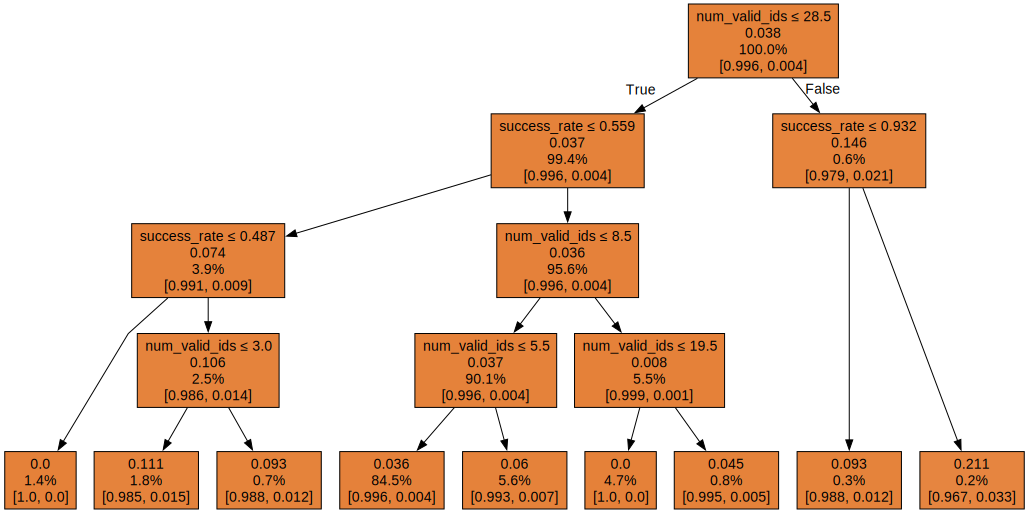

In [ ]:

# train_data = modelling_df[modelling_df['sum_payments_within_168_hours'] <= 900][regressors_all + ['new_disputer_30d']].fillna(0)
train_data = modelling_df[modelling_df['num_valid_succeful_ids'] > 0][regressors_all + ['new_disputer_30d']].fillna(0)
# train_data = df_7d[regressors_all + ['new_disputer_30d']].fillna(0)
X_train, y_train = train_data.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 

criterion = 'log_loss' 
depth = 4
leaf_size = 60

clf = create_model(criterion, depth, leaf_size)
clf.fit(X_train, y_train)
clf = clf[0]

dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           # ,  feature_names = cols
                           # ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)

In [ ]:
train_data[train_data['success_rate'] < 0] 
train_data[train_data['success_rate'] > 0][train_data['success_rate'] < 1]['new_disputer_30d'].mean()
# train_data[train_data['success_rate'] > 0][train_data['success_rate'] < 0.8]['new_disputer_30d'].mean()

0.004961958319550115

In [ ]:
modelling_df[modelling_df['num_valid_succeful_ids'] == 0].shape[0] / modelling_df.shape[0]

0.8502421075271317

In [ ]:
train_data.shape

(25763, 5)

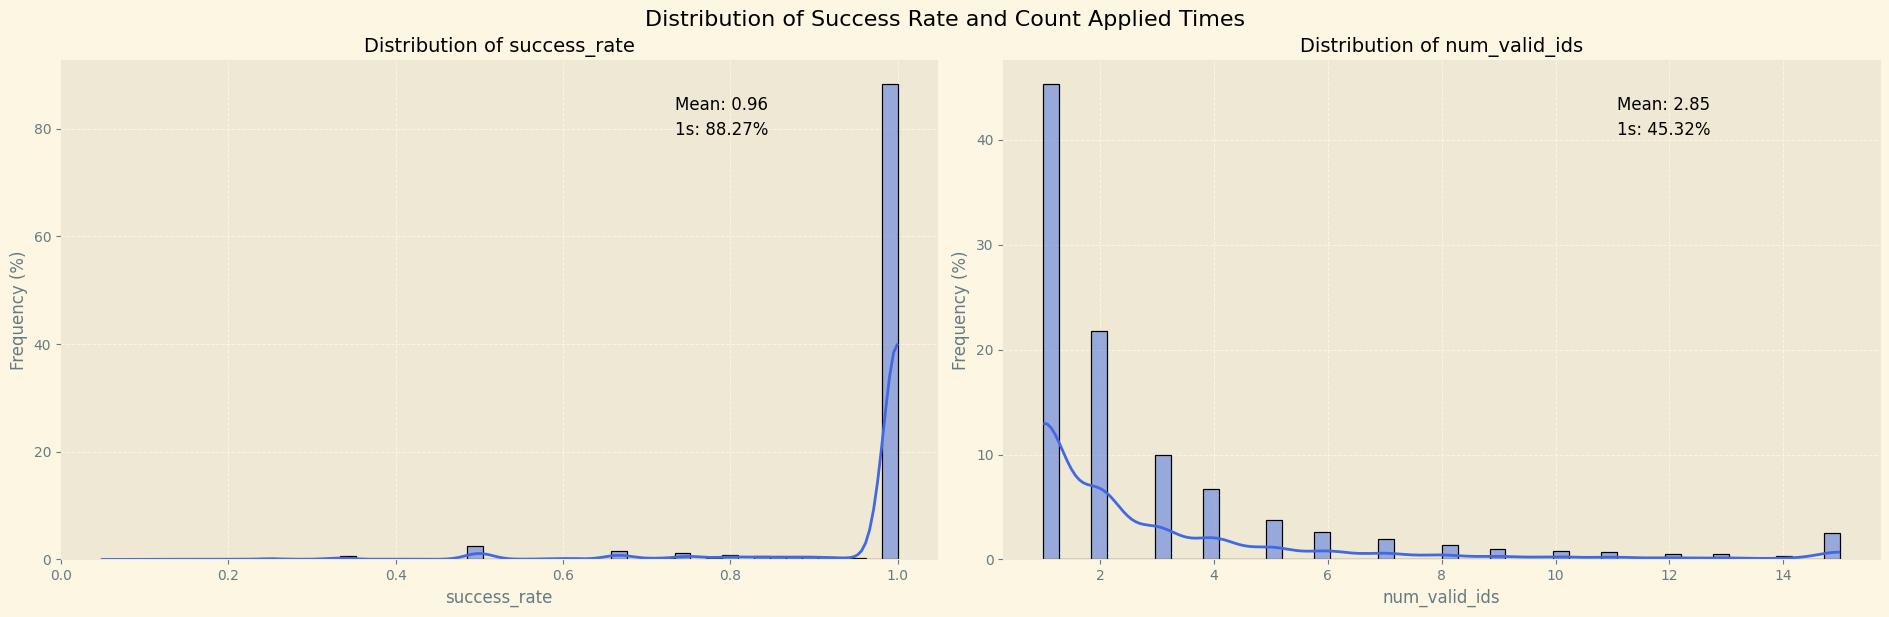

In [ ]:
# Set the style to a professional look
plt.style.use('Solarize_Light2')  # Consulting-friendly and scientific style

# Function to plot the distribution of both columns and display mean and percentage of 0s
def plot_distributions(df, columns):
    fig, axes = plt.subplots(1, 2, figsize=(19, 6))

    for ax, column in zip(axes, columns):
        # Calculate mean and percentage of 0s
        mean_value = df[column].mean()
        zero_percentage = (df[column] == 1).mean() * 100
        
        # Plot histogram with KDE
        sns.histplot(df[column], bins=50, kde=True, ax=ax, color='royalblue', stat='percent')
        
        # Annotate the plot with mean and zero percentage
        ax.text(0.7, 0.9, f'Mean: {mean_value:.2f}', transform=ax.transAxes, fontsize=12, color='black')
        ax.text(0.7, 0.85, f'1s: {zero_percentage:.2f}%', transform=ax.transAxes, fontsize=12, color='black')
        
        # Set titles and labels
        ax.set_title(f'Distribution of {column}', fontsize=14)
        ax.set_xlabel(column, fontsize=12)
        ax.set_ylabel('Frequency (%)', fontsize=12)
        ax.grid(True, linestyle='--', linewidth=0.7)

    # Adjust layout and show the plots
    # plt.figure(figsize=(25, 8))
    plt.tight_layout()
    plt.suptitle('Distribution of Success Rate and Count Applied Times', fontsize=16, y=1.02)
    plt.show()

# Call the function with the dataset and the columns to plot
plot_distributions(train_data[train_data['num_valid_ids'] > 0], ['success_rate', 'num_valid_ids'])


In [ ]:
train_data['new_version'] = train_data['num_valid_ids'] + 1
train_data['new_version']

0        3
1        2
2        5
3        2
4        3
        ..
76710    2
76711    3
76712    2
76713    2
76714    3
Name: new_version, Length: 25763, dtype: int64

In [ ]:
train_data['new_disputer_30d'].mean()

0.004075612312230719

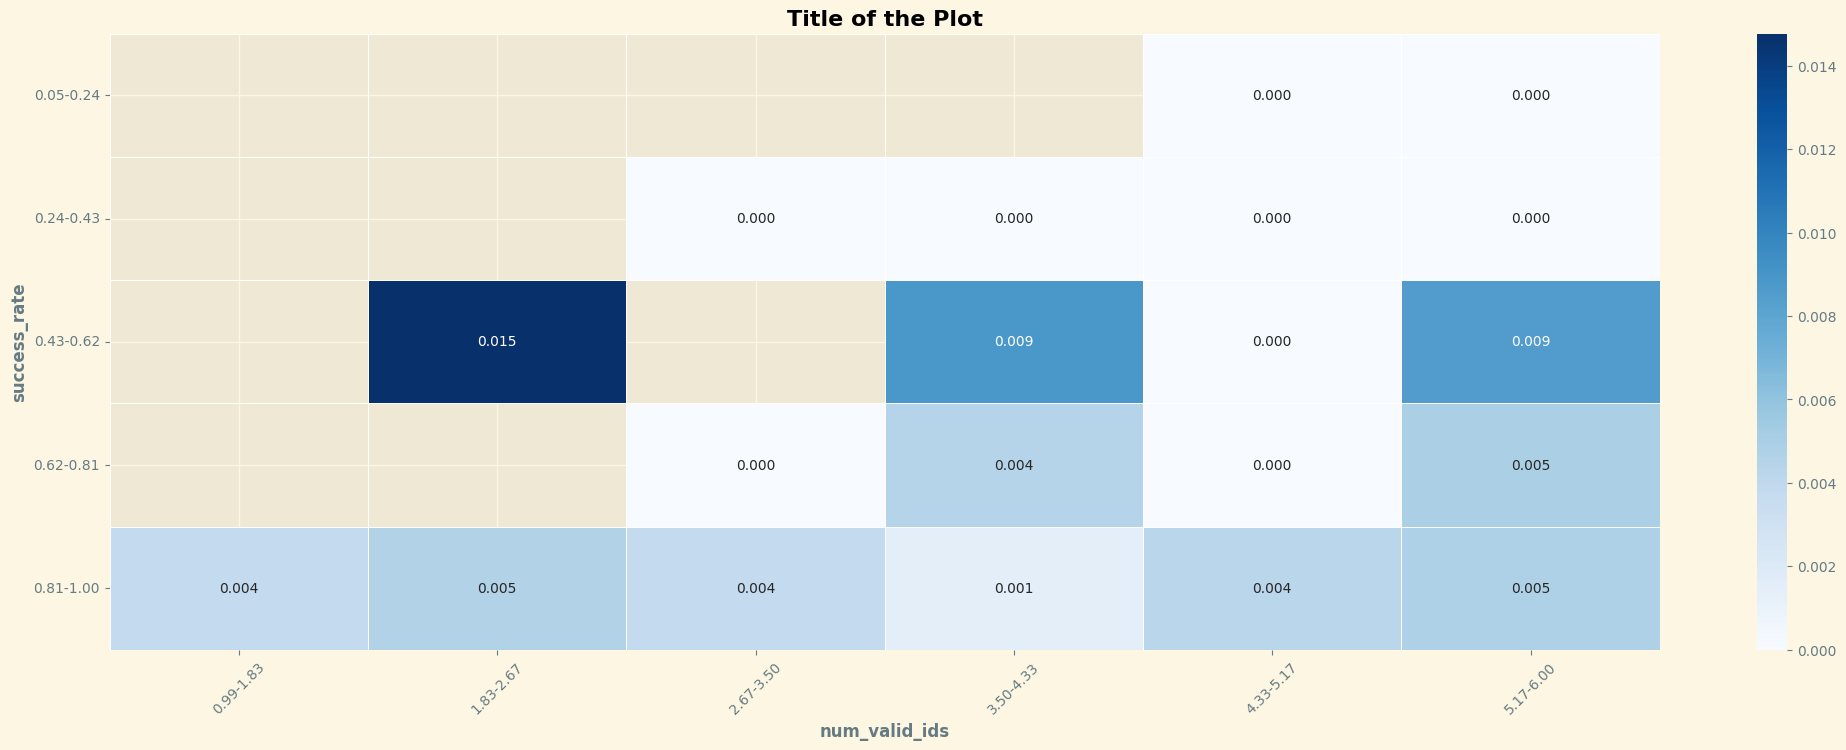

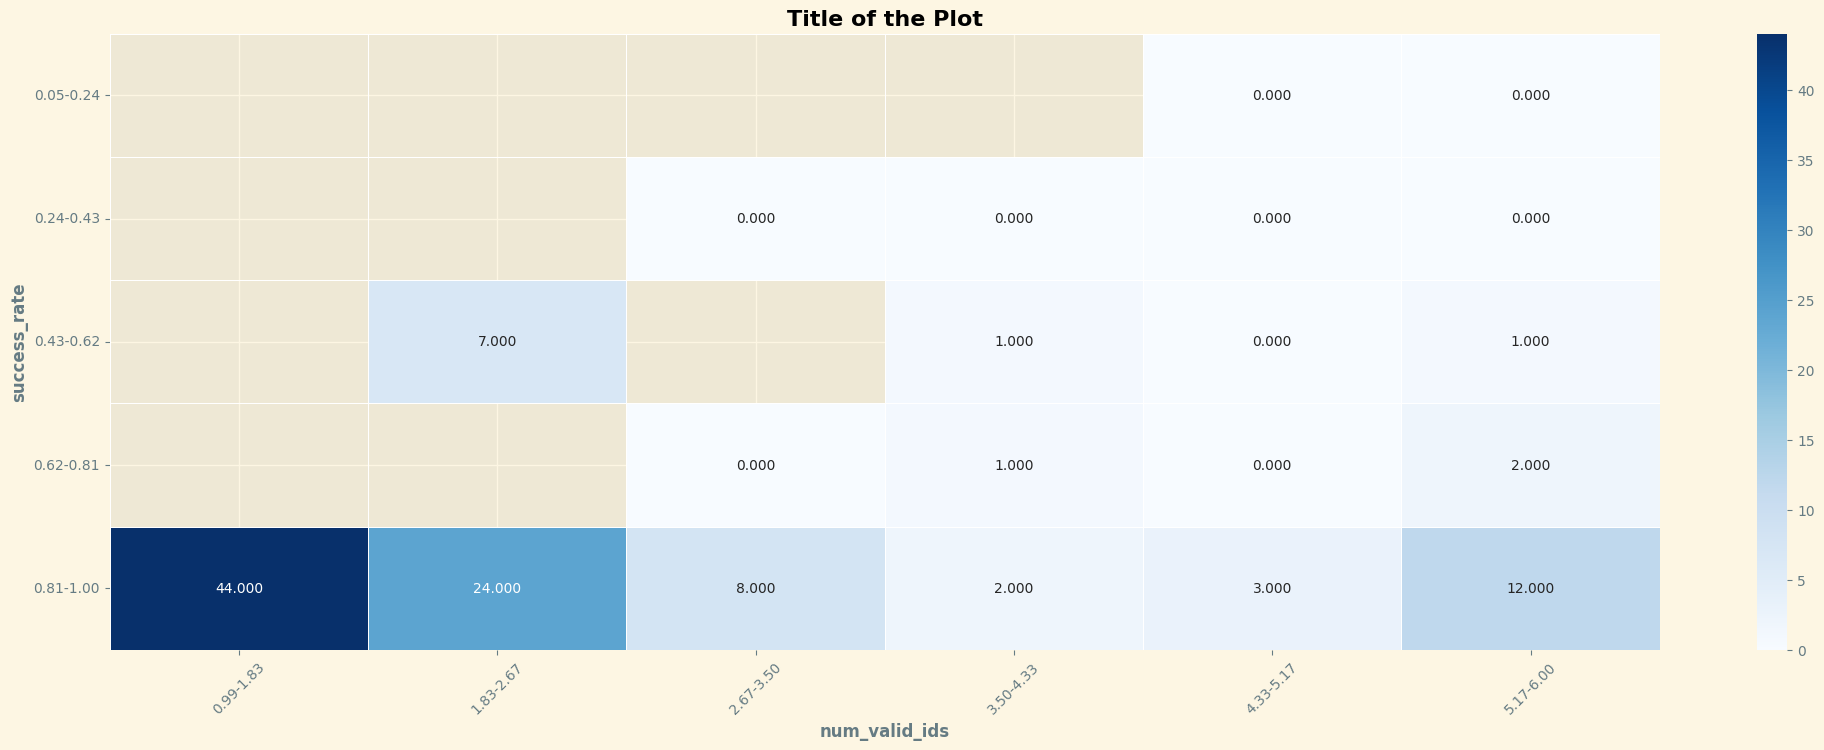

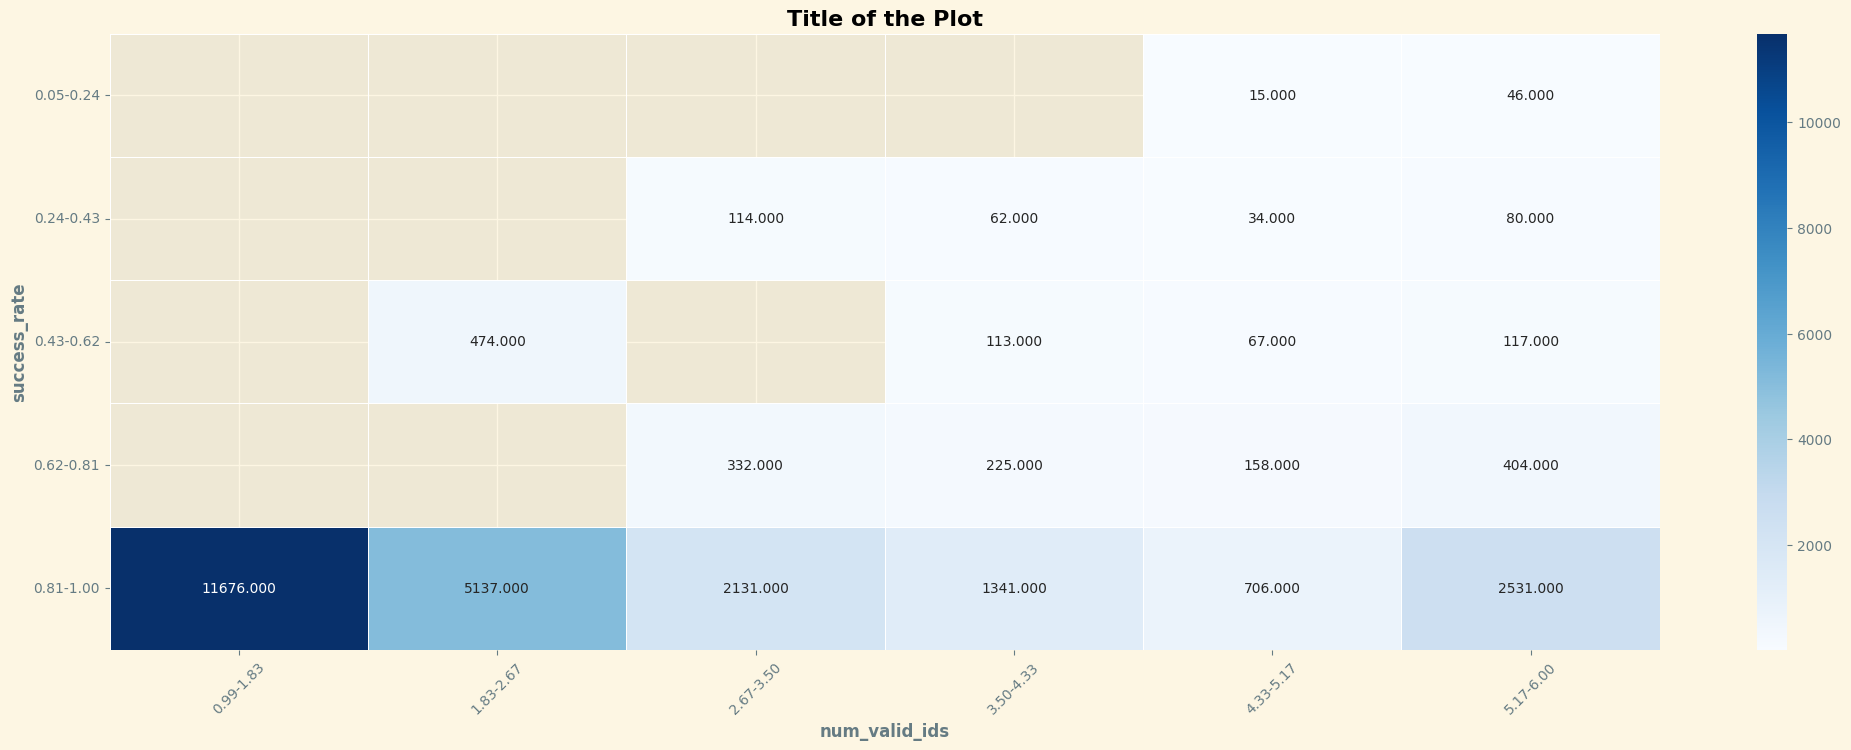

In [ ]:
# Calculate equally spaced values and get the edges
def create_and_plot_pivot_table(df, xlabel, ylabel, aggfunc, title, response_name, y_k, x_k, y_limit_number, x_limit_number):
    
    # Apply limits before cutting the data
    df[xlabel] = df[xlabel].where(df[xlabel] < x_limit_number, x_limit_number)
    df[ylabel] = df[ylabel].where(df[ylabel] < y_limit_number, y_limit_number)

    # Use pd.cut for equally spaced bins, applying limits
    df[f'{xlabel}_bin'], concerning_bets_user_bins = pd.cut(df[xlabel], bins=x_k, labels=False, retbins=True)
    df[f'{ylabel}_bin'], bets_user_bins = pd.cut(df[ylabel], bins=y_k, labels=False, retbins=True)

    # Remove NaN values that may arise due to empty bins
    df = df.dropna(subset=[f'{xlabel}_bin', f'{ylabel}_bin'])

    # Create labels for the equally spaced bins
    index_labels = [f'{bets_user_bins[i]:.2f}-{bets_user_bins[i+1]:.2f}' for i in range(len(bets_user_bins)-1)]
    columns_labels = [f'{concerning_bets_user_bins[i]:.2f}-{concerning_bets_user_bins[i+1]:.2f}' for i in range(len(concerning_bets_user_bins)-1)]

    # Create the pivot table
    contingency_table = df.pivot_table(
        index=f'{ylabel}_bin',
        columns=f'{xlabel}_bin',
        values=response_name,
        aggfunc=aggfunc
    )

    # Replace bin numbers with labels
    contingency_table.index = index_labels
    contingency_table.columns = columns_labels

    # Plotting in McKinsey-style format
    plt.figure(figsize=(25, 8))
    sns.heatmap(contingency_table, annot=True, fmt=".3f", cmap="Blues", cbar=True, linewidths=.5)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Example usage with equally spaced bins and separate limits:



# Example usage with equally spaced bins:
train_data['new_version'] = train_data['new_disputer_30d'] + 1
create_and_plot_pivot_table(train_data, 'num_valid_ids', 'success_rate', np.mean, 'Title of the Plot', 'new_disputer_30d', y_k=5, x_k=6, y_limit_number=5, x_limit_number=6)
create_and_plot_pivot_table(train_data, 'num_valid_ids', 'success_rate', np.sum, 'Title of the Plot', 'new_disputer_30d', y_k=5, x_k=6, y_limit_number=5, x_limit_number=6)
create_and_plot_pivot_table(train_data, 'num_valid_ids', 'success_rate', np.count_nonzero, 'Title of the Plot', 'new_version', y_k=5, x_k=6, y_limit_number=5, x_limit_number=6)


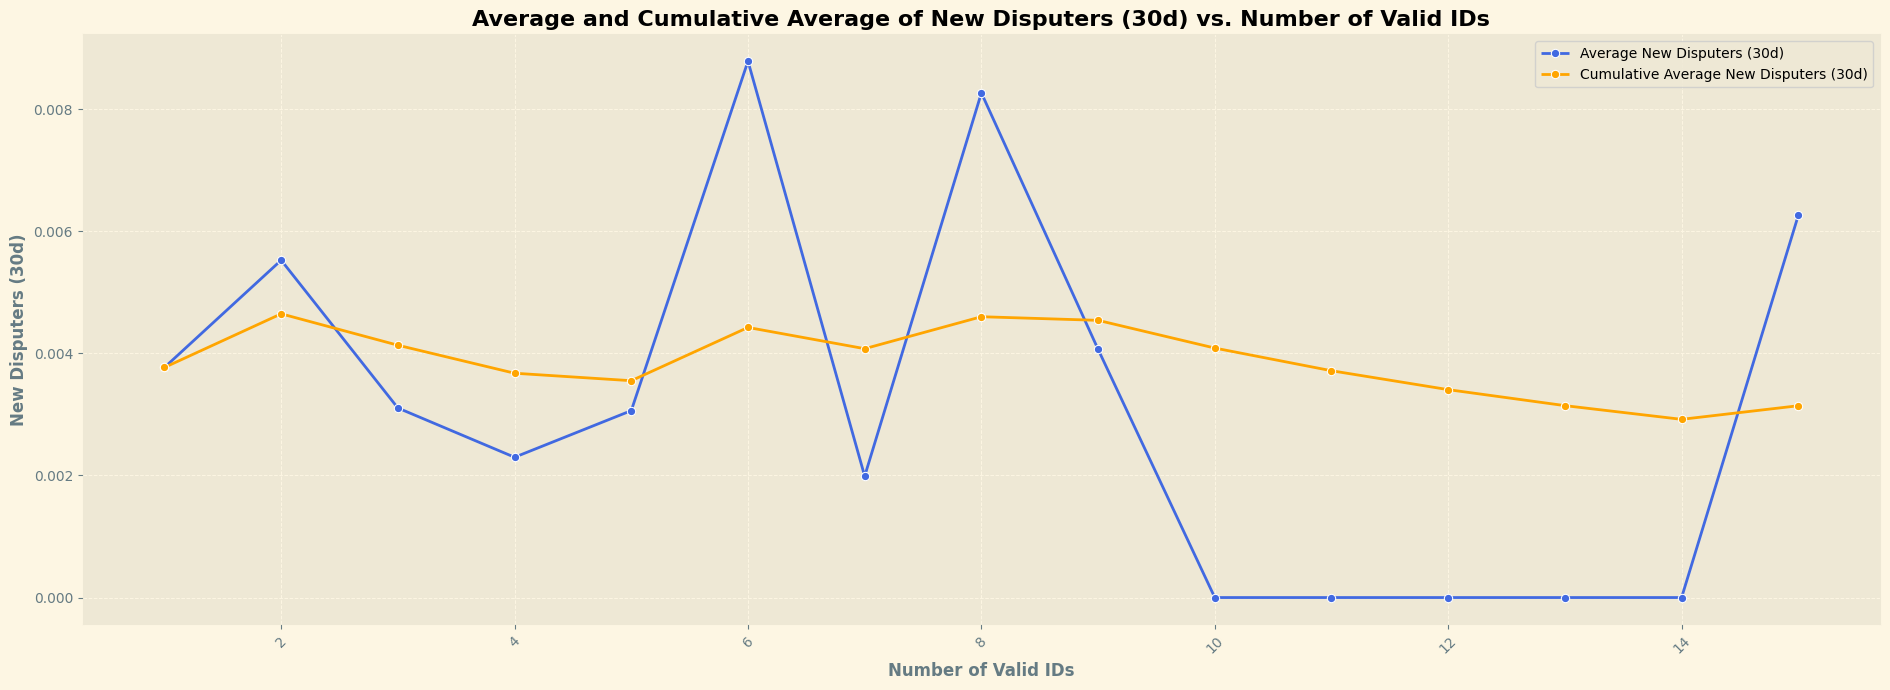

In [ ]:

average_disputers = train_data.groupby('num_valid_ids')['new_disputer_30d'].mean().reset_index()
average_disputers['cumulative_sum'] = average_disputers['new_disputer_30d'].cumsum()
average_disputers['cumulative_count'] = ((average_disputers['new_disputer_30d'] + 1)/(average_disputers['new_disputer_30d'] + 1)).cumsum()
average_disputers['cumulative_average'] = average_disputers['cumulative_sum'] / average_disputers['cumulative_count']

# Set the style to a professional look
plt.style.use('Solarize_Light2')

# Create the plot
plt.figure(figsize=(19, 7))

# Plot average
sns.lineplot(data=average_disputers, x='num_valid_ids', y='new_disputer_30d', label='Average New Disputers (30d)', color='royalblue', marker='o')

# Plot cumulative average
sns.lineplot(data=average_disputers, x='num_valid_ids', y='cumulative_average', label='Cumulative Average New Disputers (30d)', color='orange', marker='o')

# Customizing the plot
plt.title('Average and Cumulative Average of New Disputers (30d) vs. Number of Valid IDs', fontsize=16, fontweight='bold')
plt.xlabel('Number of Valid IDs', fontsize=12, fontweight='bold')
plt.ylabel('New Disputers (30d)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
modelling_df['new_disputer_30d'].mean()




0.004039969540373538

In [ ]:
train_data['new_disputer_30d'].mean()


0.004075612312230719

In [ ]:
train_data['count_applied_times_not_exceeding'].min()

1

In [ ]:

# Step 1: Create the new group column based on success_rate
def categorize_success_rate(success_rate):
    if success_rate <= 0:
        return '0'
    elif success_rate < 1:
        return '(0, 1)'
    else:
        return '1'

train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

def create_quantile_labels(series, n_quantiles):

    return pd.qcut(
        series, 
        q=n_quantiles, 
        labels=[f'Quantile {i + 1}' for i in range(n_quantiles)],
        duplicates='drop'  # Avoid duplicate bin edges
    )

# Example usage:
train_data['quantiles'] = create_quantile_labels(train_data['count_applied_times_not_exceeding'], 5)  # Create 5 quantiles

# Step 2: Plot the average of 'new_disputer_30d' for each group of 'success_rate_group' and 'count_applied_times_not_exceeding_quantile'
def plot_success_rate_vs_disputer(df):
    plt.figure(figsize=(12, 6))
    
    # Plot each 'count_applied_times_not_exceeding_quantile' group with a different line
    for group in df['quantiles'].unique():
        group_data = df[df['quantiles'] == group]
        sns.lineplot(
            data=group_data, 
            x='success_rate_group', 
            y='new_disputer_30d', 
            label=f'{group} Quantile',
            marker='o'
        )

    # Set titles and labels
    plt.title('Average new_disputer_30d by Success Rate Group and Count Applied Times Quantile', fontsize=16)
    plt.xlabel('Success Rate Group', fontsize=12)
    plt.ylabel('Average new_disputer_30d', fontsize=12)
    plt.legend(title='Count Applied Times Quantile', loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Step 3: Call the function to plot the data
plot_success_rate_vs_disputer(train_data)


ValueError: Bin labels must be one fewer than the number of bin edges

In [ ]:
train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)


In [ ]:
train_data_filtered['success_rate_group'].astype(float)

ValueError: could not convert string to float: '(0, 1)'

In [ ]:
train_data.groupby('success_rate_group')['new_disputer_30d'].mean()
train_data_filtered = train_data[train_data['success_rate_group'] == '(0, 1)']

train_data_filtered['success_rate_group_quantiles'] = create_quantile_labels(train_data_filtered['success_rate'].astype(float), 4)  # Create 5 quantiles

# train_data_filtered.groupby('success_rate_group_quantiles')['new_disputer_30d'].mean()

train_data_filtered.groupby('success_rate_group_quantiles').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()


,success_rate_group_quantiles,mean_new_disputer,sum_new_disputer
0,Quantile 1,0.027778,3
1,Quantile 2,0.070866,9
2,Quantile 3,0.000000,0
3,Quantile 4,0.000000,0


In [ ]:
train_data_filtered['count_applied_times_not_exceeding']

0         2
1         1
2         4
3         1
4         2
         ..
171273    2
171738    1
171796    2
171801    2
172028    1
Name: count_applied_times_not_exceeding, Length: 27236, dtype: int64

In [ ]:
import pandas as pd

# Step 1: Filter the DataFrame for success_rate_group '0'
train_data_filtered = train_data[train_data['success_rate_group'] == '0'].copy()

# Step 2: Ensure the count_applied_times_not_exceeding column is numeric
train_data_filtered['count_applied_times_not_exceeding'] = pd.to_numeric(
    train_data_filtered['count_applied_times_not_exceeding'], errors='coerce'
)

# Step 3: Drop NaN values from the relevant column
train_data_filtered.dropna(subset=['count_applied_times_not_exceeding'], inplace=True)

# Step 4: Calculate the number of unique values
n_unique = train_data_filtered['count_applied_times_not_exceeding'].nunique()
n_quantiles = min(3, n_unique)  # Set to the minimum of requested quantiles or unique values

# Create quantile labels
def create_quantile_labels(series, n_quantiles):
    # If there are not enough unique values, return a series of None
    if len(series) < 2 or n_quantiles < 1:  
        return pd.Series([None] * len(series))
    
    # Use pd.qcut with duplicates='drop'
    return pd.qcut(
        series,
        q=n_quantiles,
        labels=[f'Quantile {i + 1}' for i in range(n_quantiles)],
        duplicates='drop'  # Avoid duplicate bin edges
    )

# Apply the quantile creation function
train_data_filtered['quantis'] = create_quantile_labels(train_data_filtered['count_applied_times_not_exceeding'], 2)

# Group by the quantile labels and calculate mean and sum of new_disputer_30d
summary_stats = train_data_filtered.groupby('count_applied_times_not_exceeding').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()

# Display the results
summary_stats


,count_applied_times_not_exceeding,mean_new_disputer,sum_new_disputer
0,1,0.003403,44
1,2,0.004062,24
2,3,0.003079,8
3,4,0.001157,2
4,5,0.003093,3
...,...,...,...
71,111,0.000000,0
72,119,0.000000,0
73,129,0.000000,0
74,140,1.000000,2


In [ ]:
# Step 1: Convert the column to integer
train_data_filtered = train_data[train_data['success_rate_group'] == '0'].copy()+
train_data_filtered['count_applied_times_not_exceeding'] = train_data_filtered['count_applied_times_not_exceeding'].astype(int)

# Step 2: Apply the condition to transform the values
train_data_filtered['count_applied_times_not_exceeding'] = train_data_filtered['count_applied_times_not_exceeding'].apply(
    lambda x: ">4" if x >= 4 else x
)

train_data_filtered.groupby('count_applied_times_not_exceeding').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()


,count_applied_times_not_exceeding,mean_new_disputer,sum_new_disputer
0,1,0.003403,44
1,2,0.004062,24
2,3,0.003079,8
3,>4,0.002932,17


In [ ]:
train_data_filtered['count_applied_times_not_exceeding'].sample(5)

73238     3
71507     1
724      11
1125      1
17802     1
Name: count_applied_times_not_exceeding, dtype: int64

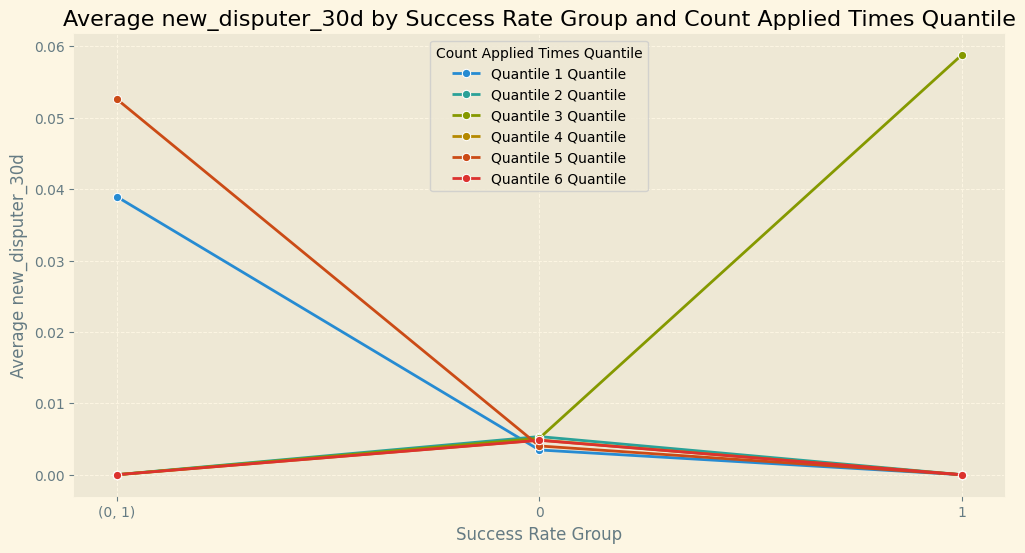

In [ ]:
def categorize_success_rate(success_rate):
    if success_rate <= 0:
        return '0'
    elif success_rate < 1:
        return '(0, 1)'
    else:
        return '1'

train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

def create_quantile_labels(series, n_quantiles):
    series = series.dropna()
    unique_values = series.nunique()
    n_quantiles = min(n_quantiles, unique_values)
    quantiles = pd.qcut(series, q=n_quantiles, labels=False, duplicates='drop')
    unique_quantiles = quantiles.unique()
    labels = [f'Quantile {i + 1}' for i in range(len(unique_quantiles))]
    quantile_labels = pd.Series(labels, index=unique_quantiles)
    return quantile_labels[quantiles].reset_index(drop=True)

# Create quantiles for count_applied_times_not_exceeding
train_data['quantiles'] = create_quantile_labels(train_data['count_applied_times_not_exceeding'], 20)

# Step 2: Calculate average new_disputer_30d for each combination of success_rate_group and quantiles
grouped_data = (train_data
                .groupby(['success_rate_group', 'quantiles'])
                .agg(average_new_disputer=('new_disputer_30d', 'mean'))
                .reset_index())

# Step 3: Plot the average of 'new_disputer_30d' for each group of 'success_rate_group' and 'quantiles'
def plot_success_rate_vs_disputer(grouped_data):
    plt.figure(figsize=(12, 6))

    # Plot each 'count_applied_times_not_exceeding_quantile' group with a different line
    for group in grouped_data['quantiles'].unique():
        group_data = grouped_data[grouped_data['quantiles'] == group]
        
        # Ensure there is data to plot
        if not group_data.empty:
            sns.lineplot(
                data=group_data, 
                x='success_rate_group', 
                y='average_new_disputer', 
                label=f'{group} Quantile',
                marker='o'
            )

    # Set titles and labels
    plt.title('Average new_disputer_30d by Success Rate Group and Count Applied Times Quantile', fontsize=16)
    plt.xlabel('Success Rate Group', fontsize=12)
    plt.ylabel('Average new_disputer_30d', fontsize=12)
    plt.legend(title='Count Applied Times Quantile', loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Step 4: Call the function to plot the data
plot_success_rate_vs_disputer(grouped_data)


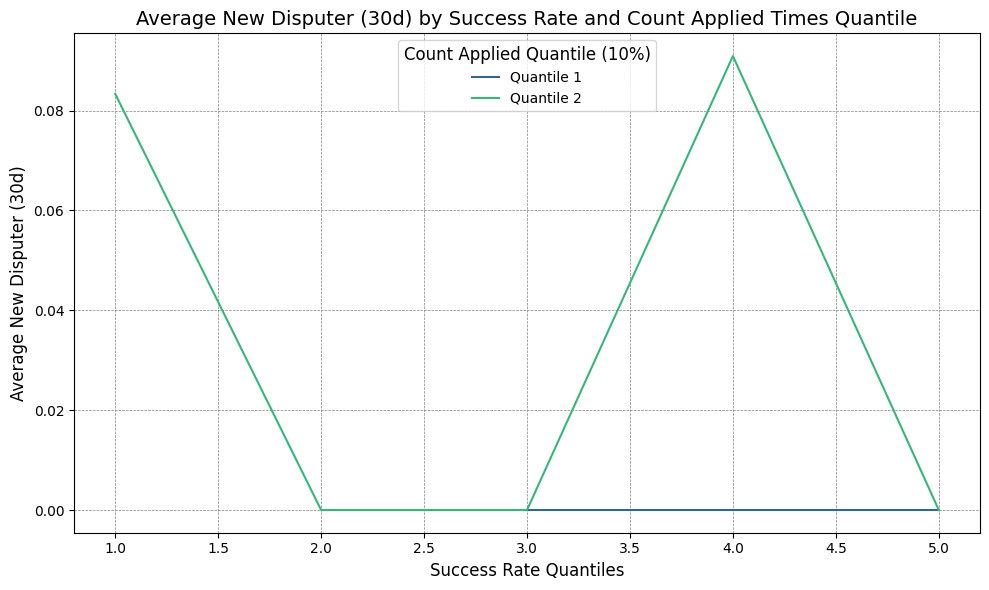

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create the desired chart
def plot_success_rate_vs_disputer(df, x_column, y_column, color_column, num_quantiles, drop_duplicates=True):
    # Option to handle non-unique bin edges by ranking or dropping duplicates
    if drop_duplicates:
        df = df.drop_duplicates(subset=[x_column, color_column])

    # Calculate quantiles for success_rate (X-axis) and count_applied_times_not_exceeding (Color)
    df['success_rate_quantile'] = pd.qcut(df[x_column].rank(method='first'), q=5, labels=np.arange(1, 6))  # 10 quantiles for success_rate
    df['count_applied_quantile'] = pd.qcut(df[color_column].rank(method='first'), q=num_quantiles, labels=np.arange(1, num_quantiles + 1))  # 8 quantiles for color

    # Group by success_rate_quantile and count_applied_quantile, and calculate the mean of new_disputer_30d
    grouped = df.groupby(['success_rate_quantile', 'count_applied_quantile'])[y_column].mean().reset_index()

    # Pivot the data to get the format needed for plotting
    pivot_df = grouped.pivot(index='success_rate_quantile', columns='count_applied_quantile', values=y_column)

    # McKinsey-style and scientific-style chart setup
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", num_quantiles)  # Use a scientific color palette

    # Plot each quantile as a separate line
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f'Quantile {col}', color=colors[int(col)-1])

    # Add labels and title
    plt.title('Average New Disputer (30d) by Success Rate and Count Applied Times Quantile', fontsize=14)
    plt.xlabel('Success Rate Quantiles', fontsize=12)
    plt.ylabel('Average New Disputer (30d)', fontsize=12)

    # Add grid, legend, and format
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.legend(title='Count Applied Quantile (10%)', title_fontsize=12, fontsize=10)
    
    # Set valid style
    plt.style.use('Solarize_Light2')  # Valid style name

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage (assuming merged_df is the DataFrame)
plot_success_rate_vs_disputer(train_data, 'success_rate', 'new_disputer_30d', 'count_applied_times_not_exceeding', num_quantiles=2)


### Some confirmation

- Why do you have negative values? 

- You know that non-integer success rates are not necessarily giving high dispute rates

- 0% is better than 1%, is 0% dangerous if applications have been made more times

- Is there any insight within non-integer rates?